# Risk and Model Uncertainty

## Overview

As an introduction to one possible approach to modeling **Knightian  uncertainty**, 
this lecture describes static representations of five classes of preferences over risky prospects. 

These preference specifications  allow  us to distinguish **risk** from **uncertainty** along lines proposed by
{cite}`Knight:1921`.  

All  five preference specifications incorporate **risk aversion**, meaning displeasure from  risks governed by  well known probability distributions. 

Two of them also incorporate  **uncertainty aversion**, meaning  dislike of not knowing a  probability distribution.

The preference orderings are 

*  Expected utility preferences
*  Constraint preferences
*  Multiplier preferences
*  Risk-sensitive preferences
*  Ex post Bayesian expected utility preferences

This labeling  scheme is taken from {cite}`HansenSargent2001`.


Constraint and multiplier preferences express  aversion to not knowing a unique probabiity distribution
that desribes random outcomes.

Expected utility, risk-sensitive, and ex post Bayesian expected utility preferences all attribute a unique known
probability distribution to a decision maker.

We present things in a simple before-and-after one-period setting.  

In addition to learning about these preference orderings, this lecture also describes some interesting code for computing and graphing some representations  of indifference curves, utility functions, and related objects.

Staring at these indifference curves provides insights into the different preferences.  

Watch for the presence of a kink at the $45$ degree line for the constraint preference indifference curves.

We begin with some that we'll use to create some graphs.

In [1]:
# Package imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)
from matplotlib import rc, cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize, stats
from scipy.io import loadmat
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from numba import njit

In [2]:
# Plotting parameters
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rc('text', usetex=True)

label_size = 20
label_tick_size = 18
title_size = 24
legend_size = 16
text_size = 18

mpl.rcParams['axes.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_tick_size 
mpl.rcParams['xtick.labelsize'] = label_tick_size 
mpl.rcParams['axes.titlesize'] = title_size
mpl.rcParams['legend.fontsize'] = legend_size
mpl.rcParams['font.size'] = text_size

In [3]:
# Useful functions
@njit
def ent(π, π_hat):
    """
    Compute the relative entropy of a probability vector `π_hat` with respect to `π`. JIT-compiled using Numba.
    
    """
    ent_val = -np.sum(π_hat * (np.log(π) - np.log(π_hat)))
    
    return ent_val


def T_θ_factory(θ, π):
    """
    Return an operator `T_θ` for a given penalty parameter `θ` and probability distribution vector `π`.
    
    """
    def T_θ(u):  
        """
        Risk-sensitivity operator of Jacobson (1973) and Whittle (1981) taking a function `u` as argument.
        
        """
        return lambda c: -θ * np.log(np.sum(π * np.exp(-u(c) / θ)))
    
    return T_θ


def compute_change_measure(u, c, θ, π):
    """
    Compute the channge of measure given a utility function `u`, a consumption vector `c`,
    a penalty parameter `θ` and a baseline probability vector `π` 
    
    """
    
    m_unnormalized = np.exp(-u(c) / θ)
    m =  m_unnormalized / (π * m_unnormalized).sum()
    return m


def utility_function_factory(α):
    """
    Return a CRRA utility function parametrized by `α` 
    
    """
    if α == 1.:
        return lambda c: np.log(c)
    else: 
        return lambda c: c ** (1 - α) / (1 - α)

## Basic objects

Basic ingredients are 

*  a set of states of the world
*  plans describing outcomes as functions of the state of the world,
*  a utility function mapping outcomes into utilities
*  either a probability distribution or a **set** of probability distributions over states of the world; and 
*  a way of measuring a discrepancy between two probability distributions.


In more detail, we'll work with the following setting.

*  A finite set of possible **states** ${\cal I} = \{i= 1, \ldots, I\}$.
*  A (consumption) **plan** is a function $c: {\cal I} \rightarrow {\mathbb R}$.  
* $u: {\mathbb R} \rightarrow {\mathbb R}$  is a **utility function**.
* $\pi$ is an $I \times 1$ vector of nonnegative **probabilities** over  states, with $\pi_ i \geq 0, \sum_{i=1}^I \pi_i = 1$.
* **Relative entropy**  $ \textrm{ent}(\pi, \hat \pi)$ of a probability vector  $\hat \pi$ with respect to a probability vector $\pi$ is the expected value of the logarithm of the  likelihood ratio $m_i \doteq \Bigl( \frac{\hat \pi_i}{\pi_i} \Bigr) $  under   distribution $\hat \pi$ defined as:  
   
   
$$
\textrm{ent}(\pi, \hat \pi) = \sum_{i=1}^I \hat \pi_i  \log \Bigl( \frac{\hat \pi_i}{\pi_i} \Bigr)   = \sum_{i=1}^I \pi_i \Bigl( \frac{\hat \pi_i}{\pi_i} \Bigr) \log \Bigl( \frac{\hat \pi_i}{\pi_i} \Bigr)  
$$ 

or 

$$
\textrm{ent}(\pi, \hat \pi) = \sum_{i=1}^I \pi_i m_i \log m_i  .
$$


**Remark:** A likelihood ratio $m_i$ is a discrete random variable. For any discrete random variable $\{x_i\}_{i=1}^I$, the expected  value of $x$  under the $\hat \pi_i$ distribution can be represented as the expected  value  under the $\pi$ distribution of the product of  $x_i$ times the `shock'  $m_i$:

$$
\hat E x = \sum_{i=1}^I x_i \hat \pi_i = \sum_{i=1}^I m_i x_i  \pi_i = E m x ,
$$
 
where $\hat E$ is the mathematical  expectation under the $\hat \pi$ distribution and $E$ is the expectation under the $\pi$ distribution. 
 
Evidently, 

$$ 
\hat E 1 = E m = 1
$$ 

and relative entropy is 

$$
E m \log m  = \hat E \log m .
$$

In the three figures below, we plot relative entropy from several perspectives.

Our first figure depicts  entropy as a function of $\hat \pi_1$ when $I=2$ and $\pi_1 = .5$. 
 
When $\pi_1 \in (0,1)$, entropy is finite for both $\hat \pi_1 = 0$  and $\hat \pi_1 = 1$ because $\lim_{x\rightarrow 0} x \log x = 0$  
 
 
However, when $\pi_1=0$ or $\pi_1=1$, entropy  is infinite.

In [4]:
# Specify baseline probability vector `π`
π = np.array([0.5, 0.5])

# Construct grid for `π_hat_0` values
min_prob = 1e-2
π_hat_0_nb = 201
π_hat_0_vals = np.linspace(min_prob, 1 - min_prob, num=π_hat_0_nb)

# Initialize `π_hat` vector with arbitrary values
π_hat = np.empty(2)

# Initialize `ent_vals` to store entropy values
ent_vals = np.empty(π_hat_0_vals.size)

for i in range(π_hat_0_vals.size):  # Loop over all possible values for `π_hat_0` 
    # Update `π_hat` values
    π_hat[0] = π_hat_0_vals[i]
    π_hat[1] = 1 - π_hat_0_vals[i]
    
    # Compute and store entropy value
    ent_vals[i] = ent(π, π_hat)

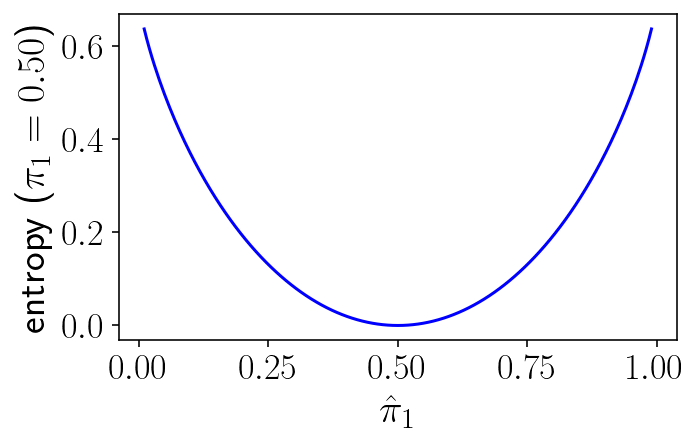

In [5]:
plt.figure(figsize=(5, 3))
plt.plot(π_hat_0_vals, ent_vals, color='blue');
plt.ylabel(r'entropy ($\pi_{1}=%.2f$)' % π[0] );
plt.xlabel(r'$\hat{\pi}_1$');
plt.show()

The heat maps in  the next two  figures vary both $\hat{\pi}_1$ and $\pi_1$.

The following figure plots  entropy.

In [6]:
# Use same grid for `π_0_vals` as for `π_hat_0_vals` 
π_0_vals = π_hat_0_vals.copy() 

# Initialize matrix of entropy values
ent_vals_mat = np.empty((π_0_vals.size, π_hat_0_vals.size))

for i in range(π_0_vals.size):  # Loop over all possible values for `π_0` 
    # Update `π` values
    π[0] = π_0_vals[i]
    π[1] = 1 - π_0_vals[i]
    
    for j in range(π_hat_0_vals.size):  # Loop over all possible values for `π_hat_0` 
        # Update `π_hat` values
        π_hat[0] = π_hat_0_vals[j]
        π_hat[1] = 1 - π_hat_0_vals[j]
        
        # Compute and store entropy value
        ent_vals_mat[i, j] = ent(π, π_hat)

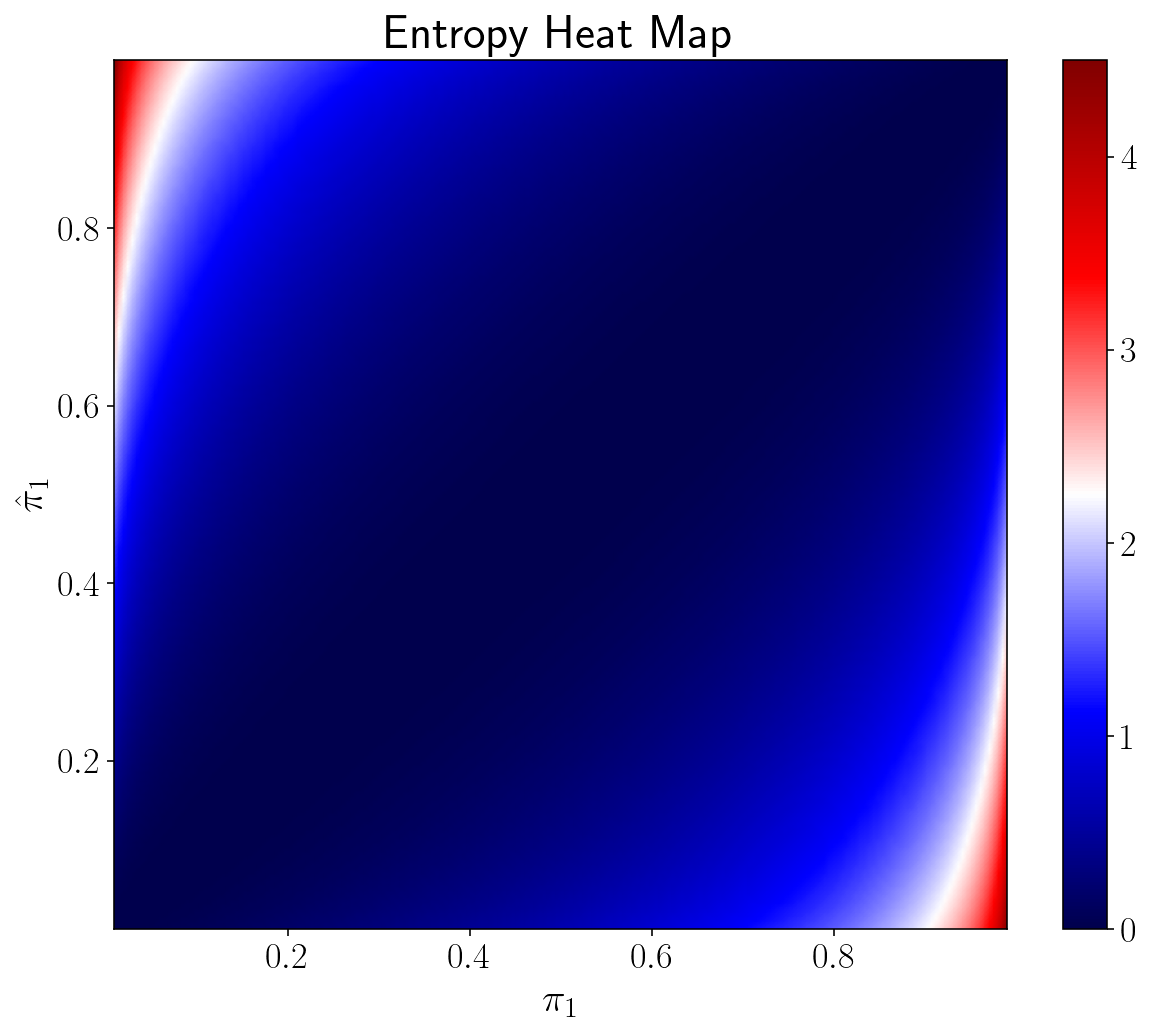

In [7]:
x, y = np.meshgrid(π_0_vals, π_hat_0_vals)
plt.figure(figsize=(10, 8))
plt.pcolormesh(x, y, ent_vals_mat.T, cmap='seismic', shading='gouraud')
plt.colorbar();
plt.ylabel(r'$\hat{\pi}_1$');
plt.xlabel(r'$\pi_1$');
plt.title('Entropy Heat Map');
plt.show()

The next figure plots  the logarithm of entropy.

In [8]:
# Check the point (0.01, 0.9)
π = np.array([0.01, 0.99])
π_hat = np.array([0.9, 0.1])
ent(π, π_hat)

3.8205752275831846

/tmp/ipykernel_13712/3759713737.py:2: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(x, y, np.log(ent_vals_mat.T), shading='gouraud', cmap='seismic')


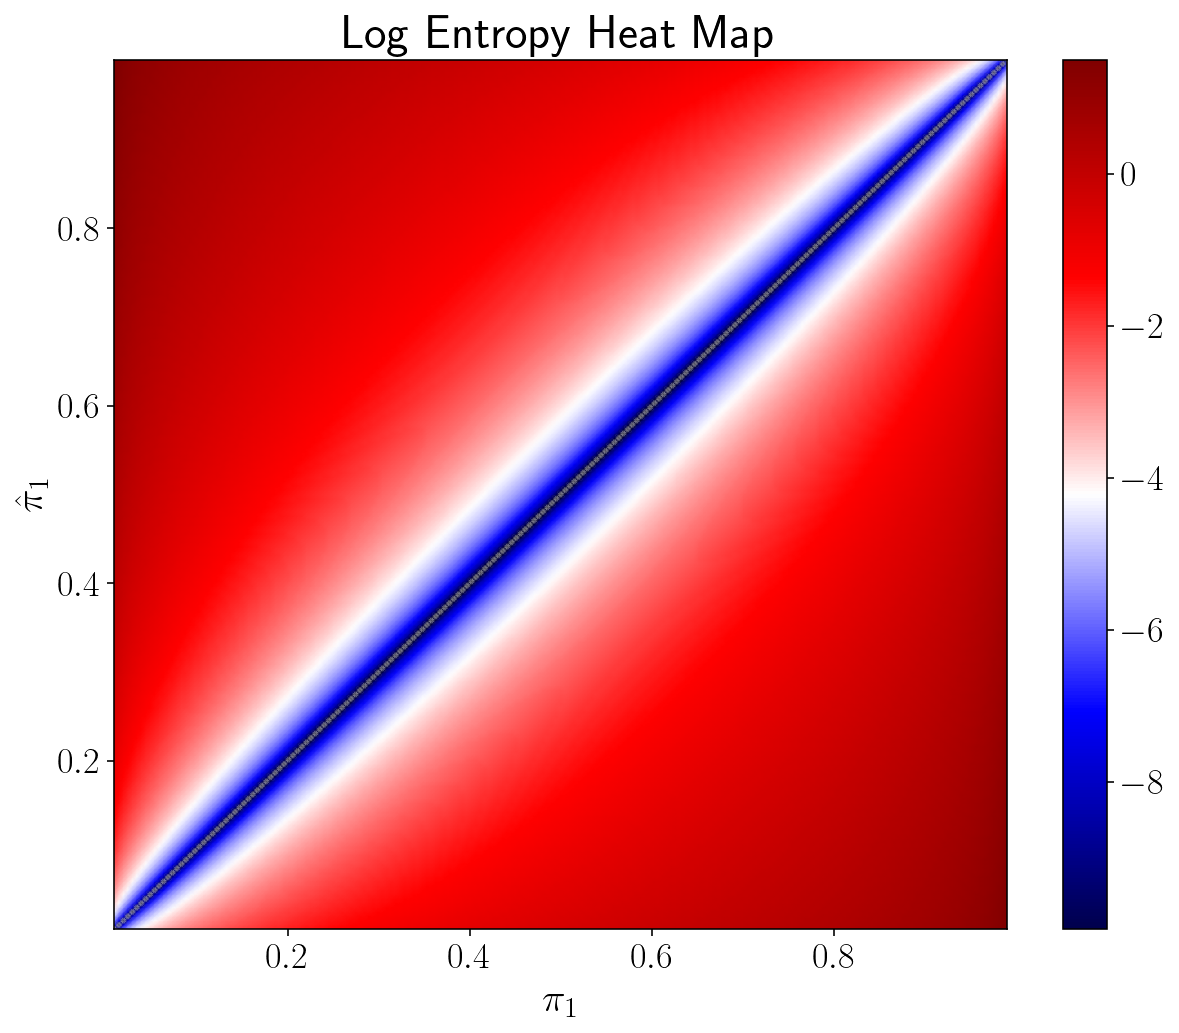

In [9]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(x, y, np.log(ent_vals_mat.T), shading='gouraud', cmap='seismic')
plt.colorbar()
plt.ylabel(r'$\hat{\pi}_1$');
plt.xlabel(r'$\pi_1$');
plt.title('Log Entropy Heat Map');
plt.show()

## Five preference specifications

We describe five types of preferences over plans.

* Expected utility preferences 
* Constraint preferences
* Multiplier preferences
* Risk-sensitive preferences
* Ex post Bayesian expected utility preferences


Expected utility, risk-sensitive, and ex post Bayesian prefernces are  each cast in terms of a unique probability distribution, so they can express risk-aversion, but not model ambiguity aversion. 


Multiplier and constraint prefernces both  express aversion to
concerns about model misppecification, i.e., model uncertainty;  both are cast  in terms of a set or sets  of probability distributions. 

* The set of distributions expresses the decision maker's ambiguity about the probability model.
* Minimization over probability distributions expresses his aversion to ambiguity.

## Expected utility

A decision maker is said to have **expected utility preferences** when he ranks plans $c$ by their expected utilities 
  
$$
\sum_{i=1}^I u(c_i) \pi_i, 
$$ (tom1)

where $u$ is a unique utility function and $\pi$ is a unique probability measure over states.

* A known $\pi$ expresses risk.
* Curvature of $u$ expresses
risk aversion.

## Constraint preferences

A decision maker is said to have **constraint preferences** when he ranks plans $c$ according to  

$$
\min_{\{m_i \geq 0\}_{i=1}^I}  \sum_{i=1}^I m_i\pi_i  u(c_i)
$$ (tom2)

subject to

$$
\sum_{i=1}^I \pi_i m_i \log m_i \leq \eta
$$ (tom3)

and

$$
\sum_{i=1}^I \pi_i m_i = 1 .
$$ (tom4)

In {eq}`tom3`,  $\eta \geq 0$ defines an  entropy ball of probability distributions $\hat \pi = m \pi$  that surround a baseline distribution $\pi$.

As noted earlier,     $\sum_{i=1}^I m_i\pi_i  u(c_i)$ is the expected value of $u(c)$ under a twisted probability distribution $\{\hat \pi_i\}_{i=1}^I = \{m_i \pi_i\}_{i=1}^I$.

Larger values of the entropy constraint $\eta$ indicate more apprehension about the baseline probability distribution $\{\pi_i\}_{i=1}^I$.

Following {cite}`HansenSargent2001` and {cite}`HansenSargent2008`, we call minimization problem  {eq}`tom2` subject to {eq}`tom3` and{eq}`tom4` a **constraint problem**.

To find  minimizing probabilities, we form a Lagrangian

$$
L = \sum_{i=1}^I m_i \pi_i u(c_i) +  \tilde \theta\bigl[\sum_{i=1}^I \pi_i m_i \log m_i - \eta \bigr]
$$ (tom5)

where $\tilde \theta \geq 0$ is a Lagrange multiplier associated     with the entropy constraint.

Subject to the additional constraint that $\sum_{i=1}^I m_i  \pi_i =1$, we want to minimize {eq}`tom5` with respect to     $\{m_i\}_{i=1}^I$ and to maximize it with respect to   $\tilde \theta$.

The minimizing probability distortions (likelihood ratios) are

$$
\tilde m_i(c;\tilde \theta)
= \frac{ \exp \bigl(- u(c_i)/\tilde \theta\bigr)}{\sum_j \pi_j \exp \bigl(- u(c_j) /\tilde \theta\bigr) } .
$$  (tom6)



To compute the Lagrange multiplier $\tilde \theta(c, \eta)$, we must
solve

$$
\sum_i \pi_i \tilde m_i (c;\tilde \theta ) \log (\tilde m_i (c;\tilde \theta ))  = \eta
$$

or

$$
\sum_i \pi_i \frac{ \exp \bigl(- u(c_i)/\tilde \theta\bigr)}{\sum_j \pi_j \exp \bigl(- u(c_j)/\tilde \theta\bigr) }
\log \biggl[\frac{ \exp \bigl(- u(c_i)/\tilde \theta\bigr)}{\sum_j \pi_j \exp \bigl(- u(c_j)/\tilde \theta\bigr) }
\biggr] = \eta
$$ (tom7)

for $\tilde \theta = \tilde \theta(c; \eta)$.

For a fixed $\eta$, the $\tilde \theta$ that solves equation {eq}`tom7` is evidently a function of the consumption plan $c$. 

With $\tilde \theta(c;\eta)$ in hand we can obtain worst-case  probabilities as functions $\pi_i\tilde m_i(c;\eta)$ of $\eta$.

The **indirect (expected) utility function** under constraint preferences is

$$
\sum_{i=1}^I   \pi_i \tilde m_i(c_i;\eta) u(c_i) = \sum_{i=1}^I  \pi_i \left[\frac{\exp(-\tilde \theta^{-1} u(c_i))}
    {\sum_{j=1}^I \exp(-\tilde \theta^{-1} u(c_j) ) \pi_j } \right]    u(c_i) .
$$ (tom8)

Entropy evaluated at the minimizing probability distortion
{eq}`tom6` equals $E \tilde m \log \tilde m$ or

$$
\begin{aligned}
& & \sum_{i=1}^I   \left[\frac{\exp(-\tilde \theta^{-1} u(c_i))}
    {\sum_{j=1}^I \exp(-\tilde \theta^{-1} u(c_j) ) \pi_j } \right]  \times \cr
    & & \left\{ -\tilde \theta^{-1} u(c_i) + \log \left(\sum_{j=1}^I \exp(-\tilde \theta^{-1} u(c_j) ) \pi_j \right)
        \right\}  \pi_i \cr
    & = & -\tilde \theta^{-1} \sum_{i=1}^I  \pi_i \left[\frac{\exp(-\tilde \theta^{-1} u(c_i))}
    {\sum_{j=1}^I \exp(-\tilde \theta^{-1} u(c_j) ) \pi_j } \right]    u(c_i)  \cr
    & & + \log \left(\sum_{j=1}^I \exp(-\tilde \theta^{-1} u(c_j) ) \pi_j \right) .
\end{aligned}  
$$ (tom9)

Expression {eq}`tom9` implies that 

$$
\begin{aligned} 
    - \tilde \theta \log \left(\sum_{j=1}^I \exp(-\tilde \theta^{-1} u(c_j) ) \pi_j \right) & = &
    \sum_{i=1}^I  \pi_i \left[\frac{\exp(-\tilde \theta^{-1} u(c_i))}
    {\sum_{j=1}^I \exp(-\tilde \theta^{-1} u(c_j) ) \pi_j } \right]    u(c_i) \cr
    &   &   + \tilde \theta (c;\eta) \sum_{i=1}^I \log \tilde m_i(c;\eta) \tilde m_i(c;   \eta) \pi_i ,
\end{aligned} 
$$ (tom10)


where the last term is $\tilde \theta$ times the entropy of the worst-case probability distribution. 


## Multiplier preferences 

A decision maker is said to have **multiplier preferences** when he ranks consumption plans $c$    according to

$$
{\sf T}u(c) \doteq \min_{\{m_i \geq 0\}_{i=1}^I}  \sum_{i=1}^I \pi_i m_i [  u(c_i) + \theta \log m_i ]
$$ (tom11)

where minimization is subject to 

$$
\sum_{i=1}^I \pi_i m_i = 1 .
$$ 

Here $\theta \in (\underline \theta, +\infty )$ is a 'penalty parameter'  that governs a 'cost' to an 'evil alter ego' who distorts probabilities  by choosing $\{m_i\}_{i=1}^I$. 

Lower values of the penalty parameter $\theta$ express more apprehension about the baseline probability  distribution $\pi$.

Following {cite}`HansenSargent2001` and {cite}`HansenSargent2008`, we call the minimization problem on the right side of {eq}`tom11` a **multiplier problem**. 

The minimizing probability distortion that solves the multiplier problem is

$$
\hat m_i(c; \theta) = \frac{ \exp \bigl(- u(c_i)/\theta\bigr)}{\sum_j \pi_j \exp \bigl(- u(c_j)/\theta\bigr) } .
$$ (tom12)

We can solve

$$
\sum_i \pi_i \frac{ \exp \bigl(- u(c_i)/ \theta\bigr)}{\sum_j \pi_j \exp \bigl(- u(c_j)/ \theta\bigr) }
\log \biggl[\frac{ \exp \bigl(- u(c_i)/\theta\bigr)}{\sum_j \pi_j \exp \bigl(- u(c_j)/\theta\bigr) }
\biggr] = \tilde \eta
$$ (tom20)

to find an entropy level  $\tilde \eta (c; \theta)$ associated with multiplier preferences with penalty parameter $\theta$ and allocation $c$.

For a fixed $\theta$, the $\tilde \eta$ that solves equation {eq}`tom20` is a function of the consumption plan $c$

The forms of expressions {eq}`tom6`  and {eq}`tom12` are identical, but the Lagrange multiplier $\tilde \theta$ appears in {eq}`tom6`,  while the penalty parameter $\theta$ appears in {eq}`tom12`.

Formulas {eq}`tom6`  and {eq}`tom12` show that worst-case probabilities are **context specific** in the sense that they depend  on both the utility function $u$ and the consumption plan $c$.

If we add $\theta$ times entropy under the worst-case model to expected utility under the worst-case model, we find that the
**indirect expected utility function** under multiplier preferences is

$$
-  \theta \log \left(\sum_{j=1}^I \exp(- \theta^{-1} u(c_j) ) \pi_j \right) .
$$ (tom13)

## Risk-sensitive preferences 

Substituting $\hat m_i$ into $\sum_{i=1}^I \pi_i \hat m_i [  u(c_i) + \theta \log \hat m_i ]$ gives the indirect utility function

$$
{\sf T} u(c) \doteq - \theta \log \sum_{i=1}^I \pi_i \exp\bigl(- u(c_i)/\theta  \bigr).
$$ (tom14)
    
Here ${\sf T} u$ in    {eq}`tom14` is the **risk-sensitivity** operator of  {cite}`Jacobson_73`, {cite}`Whittle_1981`,  and {cite}`Whittle_1990`. 
    
It defines a **risk-sensitive** preference    ordering over plans $c$. 
    
Because it is not linear in utilities $u(c_i)$ and probabilities $\pi_i$, it is said not to be separable across states.
    
Because risk-sensitive preferences use a unique probability distribution, they apparently express no model distrust or ambiguity. 

Instead, they make an additional adjustment for risk-aversion beyond that embedded in the curvature of $u$. 

For $I=2, c_1=2, c_2=1$, $u(c) = \ln c$, the following figure plots the risk-sensitive criterion ${\sf T} u(c)$ defined in    {eq}`tom14` as a function of $\pi_1$ for values of $\theta$ of 100 and .6.

In [10]:
c_bundle = np.array([2., 1.])  # Consumption bundle
θ_vals = np.array([100, 0.6])  # Array containing the different values of θ
u = utility_function_factory(1.)  # Utility function

# Intialize arrays containing values for Tu(c)
Tuc_vals = np.empty((θ_vals.size, π_hat_0_vals.size))

for i in range(θ_vals.size):  # Loop over θ values
    for j in range(π_hat_0_vals.size):  # Loop over `π_hat_0` values
        # Update `π` values
        π[0] = π_0_vals[j]
        π[1] = 1 - π_0_vals[j]

        # Create T operator
        T = T_θ_factory(θ_vals[i], π)
        
        # Apply T operator to utility function
        Tu = T(u)
        
        # Compute and store Tu(c)
        Tuc_vals[i, j] = Tu(c_bundle)

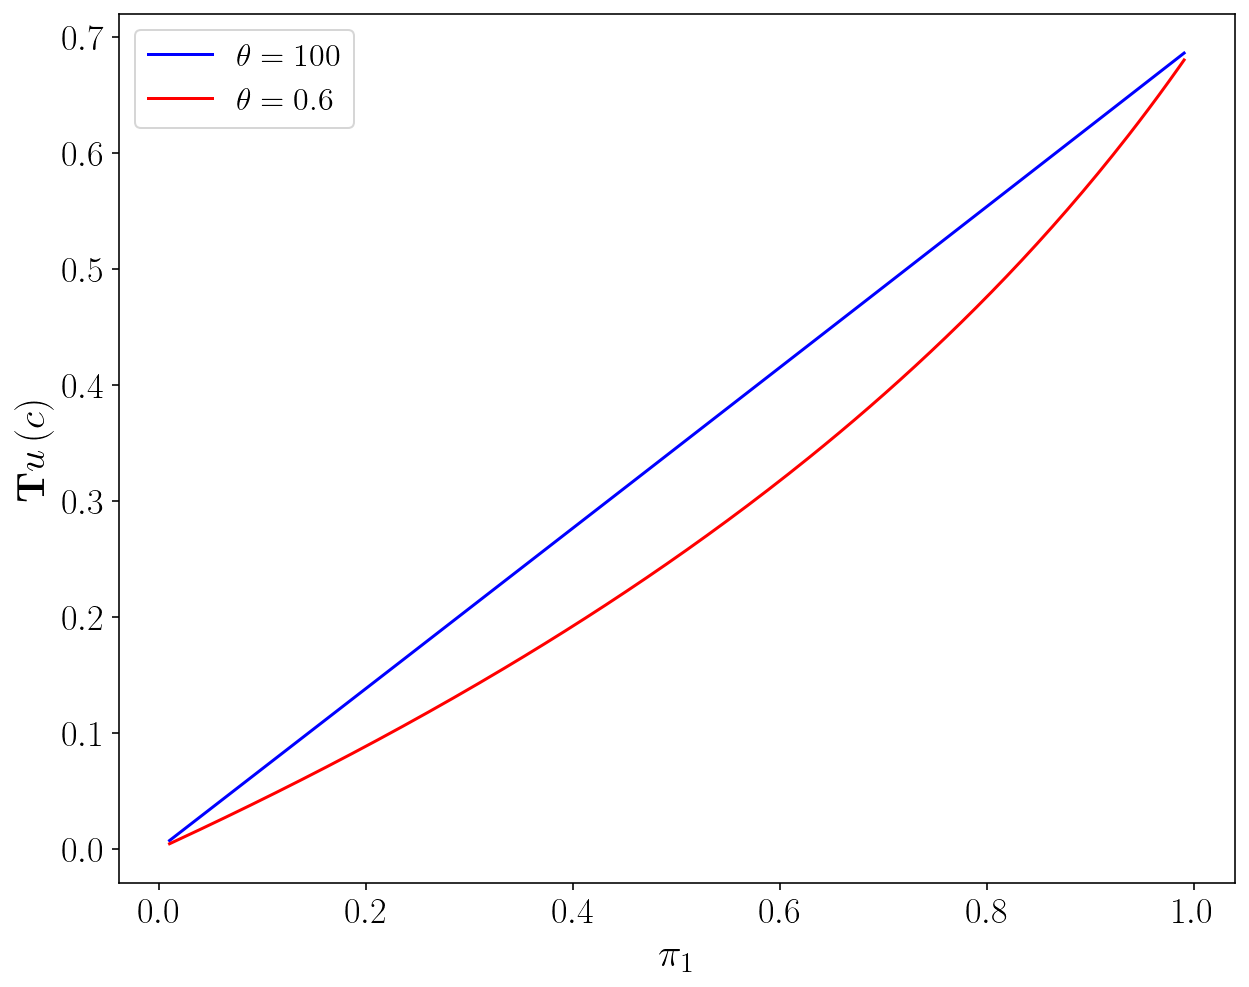

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(π_0_vals, Tuc_vals[0], label=r'$\theta=100$', color='blue');
plt.plot(π_0_vals, Tuc_vals[1], label=r'$\theta=0.6$', color='red');
plt.ylabel(r'$\mathbf{T}u\left(c\right)$');
plt.xlabel(r'$\pi_1$');
plt.legend();

For large values of $\theta$, ${\sf T} u(c)$ is approximately linear in the probability $\pi_1$, but for lower values of $\theta$, ${\sf T} u(c)$ has considerable    curvature as a function of $\pi_1$.

Under expected utility, i.e., $\theta =+\infty$, ${\sf T}u(c)$ is linear in $\pi_1$, but it is convex as a function of $\pi_1$ when $\theta< + \infty$.

The two  panels in the next  figure below  can help us to visualize the extra adjustment for risk that the risk-sensitive operator entails.  

This will help us understand  how the $\mathbf{T}$ transformation works by envisioning  what function is being averaged.

In [12]:
# Parameter values
θ= 0.8
π = np.array([0.5, 0.5])
c_bundle = np.array([2., 1.])  # Consumption bundle

# Compute the average consumption level implied by `c_bundle` wrt to `π` 
avg_c_bundle = np.sum(π * c_bundle)

# Construct grid for consumption values
c_grid_nb = 101
c_grid = np.linspace(0.5, 2.5, num=c_grid_nb)

# Evaluate utility function on the grid
u_c_grid = u(c_grid)

# Evaluate utility function at bundle points
u_c_bundle = u(c_bundle)

# Compute the average utility level implied by `c_bundle` wrt to `π` 
avg_u = np.sum(π * u_c_bundle)

# Compute the first transformation exp(-u(c) / θ) for grid values
first_trnsf_u_c_grid = np.exp(-u_c_grid / θ) 

# Compute the first transformation exp(-u(c) / θ) for bundle values
first_trnsf_u_c_bundle = np.exp(-u_c_bundle/θ)

# Take expectations in the transformed space for bundle values (second transformation)
second_trnsf_u_c_bundle = np.sum(π * first_trnsf_u_c_bundle)

# Send expectation back to the original space (third transformation)
third_trnsf_u_c_bundle = -θ * np.log(second_trnsf_u_c_bundle)

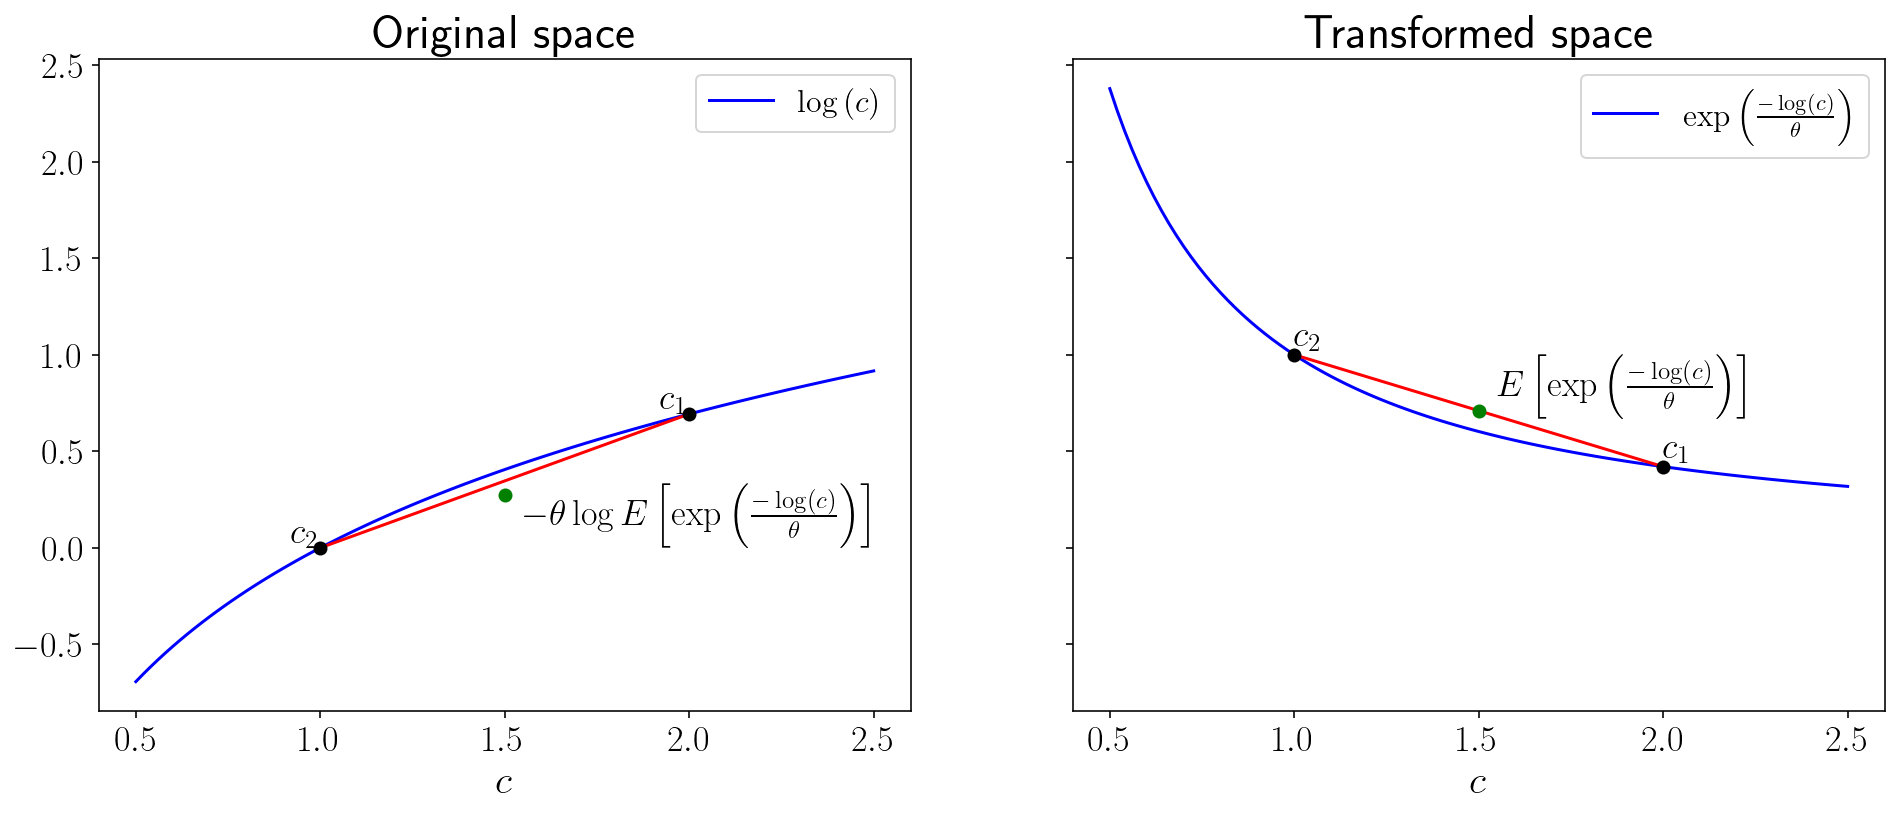

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

ax1.plot(c_grid, u_c_grid, label=r'$\log\left(c\right)$', color='blue')
ax1.plot(c_bundle, u_c_bundle, color='red')
ax1.plot(avg_c_bundle, third_trnsf_u_c_bundle, 'o', color='green');
ax1.annotate(r'$-\theta\log E\left[\exp\left(\frac{-\log\left(c\right)}{\theta}\right)\right]$',
             (avg_c_bundle+0.05, third_trnsf_u_c_bundle-0.15))

# Consumption dots
ax1.plot(c_bundle[0], u_c_bundle[0], 'o', color='black')
ax1.plot(c_bundle[1], u_c_bundle[1], 'o', color='black')
ax1.annotate(r'$c_1$', (c_bundle[0]-0.08, u_c_bundle[0]+0.03))
ax1.annotate(r'$c_2$', (c_bundle[1]-0.08, u_c_bundle[1]+0.03))
ax1.set_xlabel(r'$c$')

ax1.set_title('Original space')
ax1.legend()

ax2.plot(c_grid, first_trnsf_u_c_grid, label=r'$\exp\left(\frac{-\log\left(c\right)}{\theta}\right)$', color='blue');
ax2.plot(c_bundle, first_trnsf_u_c_bundle, color='red')
ax2.plot(avg_c_bundle, second_trnsf_u_c_bundle, 'o', color='green')
ax2.annotate(r'$E\left[\exp\left(\frac{-\log\left(c\right)}{\theta}\right)\right]$',
             (avg_c_bundle+0.05, second_trnsf_u_c_bundle+0.08))

# Consumption dots
ax2.plot(c_bundle[0], first_trnsf_u_c_bundle[0], 'o', color='black')
ax2.plot(c_bundle[1], first_trnsf_u_c_bundle[1], 'o', color='black')
ax2.annotate(r'$c_1$', (c_bundle[0], first_trnsf_u_c_bundle[0]+0.05))
ax2.annotate(r'$c_2$', (c_bundle[1], first_trnsf_u_c_bundle[1]+0.05))
ax2.set_xlabel(r'$c$')

ax2.set_title('Transformed space')
ax2.legend();

The panel on the right portrays how the transformation $\exp\left(\frac{-u\left(c\right)}{\theta}\right)$ sends $u\left(c\right)$ to a new function by  (i)  flipping the  sign,  and (ii) increasing curvature in proportion to $\theta$.

In the left panel, the red line is our tool for computing  the mathematical expectation for different
values  of $\pi$.

The green lot indicates the mathematical expectation of $\exp\left(\frac{-u\left(c\right)}{\theta}\right)$ 
when $\pi = .5$.  

Notice that the distance between the green dot  and the curve is greater in the transformed space than the original space as a result of additional curvature. 

The inverse transformation  $\theta\log E\left[\exp\left(\frac{-u\left(c\right)}{\theta}\right)\right]$ generates  the green dot on the left panel that constitutes the risk-sensitive utility  index.  

The gap between the green dot and the red line on the left panel measures the additional adjustment for risk
that risk-sensitive preferences make relative to plain vanilla expected utility preferences.

### Digression on moment generating functions

The risk-sensitivity operator ${\sf T}$ is intimately connected to a moment generating function.

In particular, a principal constinuent of the ${\sf T}$ operator, namely,  

$$
E \exp\bigl(-u(c_i)/\theta\bigr) = \sum_{i=1}^I \pi_i \exp\bigl(- u(c_i)/\theta  \bigr)
$$

is evidently a **moment generating function** for the random variable $u(c_i)$, while 
 
$$
g(\theta^{-1}) \doteq  \log \sum_{i=1}^I \pi_i \exp\bigl(- u(c_i)/\theta  \bigr)
$$
 
is a **cumulant generating function**, 
 
$$
g(\theta^{-1}) = \sum_{j=1}^\infty \kappa_j \frac{{(-\theta^{-1})}^{j}}{j!}. 
$$ 

where $\kappa_j$ is the $j$th cumulant of the random variable $u(c)$.

Then 

$$
{\sf T}u(c) = -\theta g(\theta^{-1}) = -\theta \sum_{j=1}^\infty \kappa_j \frac{{(-\theta^{-1})}^{j}}{j!}.
$$ 

In general, when $\theta < +\infty$, ${\sf T} u(c)$ depends on cumulants of all orders.

These statements extend to cases with continuous probability distributions for $c$ and therefore for $u(c)$. 

For the special case $u(c) \sim {\mathcal N}(\mu_u, \sigma_u^2)$, $\kappa_1 = \mu_u, \kappa_2 = \sigma_u^2,$  and $\kappa_j = 0 \ \forall j \geq 3$, so 

$$
 {\sf T} u(c) = \mu_u - \frac{1}{2 \theta} \sigma_u^2, 
$$ (tom200)

which becomes expected utility $\mu_u$ when $\theta^{-1} = 0$.

The right side of equation {eq}`tom200` is a special case of **stochastic differential utility** preferences in which consumption plans are ranked not just by their expected utilities $\mu_u$ but also the variances $\sigma_u^2$  of their expected utilities.

## Ex post Bayesian preferences 

A decision maker is said to have **ex post Bayesian preferences** when he ranks consumption plans according to the expected utility function    

$$
\sum_i \hat \pi_i (c^*) u(c_i)
$$ (tom15)

where $\hat \pi(c^*)$ is the worst-case probability distribution associated with multiplier or constraint preferences evaluated at a particular consumption plan $c^* = \{c_i^*\}_{i=1}^I$.

At $c^*$, an ex post Bayesian's indifference curves are tangent to those for multiplier and constraint preferences with appropriately chosen $\theta$ and $\eta$, respectively.

## Comparing preferences

For the special case in which $I=2$, $c_1=2, c_2=1$, $u(c) = \ln c$, and
$\pi_1 =.5$, the following two figures depict how worst-case
probabilities are determined under  constraint and multiplier preferences, respectively.

The first figure  graphs entropy as a function of $\hat \pi_1$.

It also plots expected utility under the twisted probability distribution, namely,
$\hat E u(c) = u(c_2) + \hat \pi_1 (u(c_1) - u(c_2))$, which is
evidently a linear function of $\hat \pi_1$. 

The entropy constraint  $\sum_{i=1}^I \pi_i m_i \log m_i \leq \eta$ implies a convex set
$\hat \Pi_1$ of $\hat \pi_1$'s that constrains the adversary who chooses $\hat \pi_1$, namely, the set of $\hat \pi_1$'s for which the
entropy curve lies below the horizontal dotted line at an entropy level of $\eta = .25$. 

Unless $u(c_1) = u(c_2)$, the $\hat \pi_1$ that minimizes $\hat E u(c)$ is at the boundary of the set $\hat \Pi_1$.

In [14]:
# Parameter 
η = 0.25
π = np.array([0.5, 0.5])
c_bundle = np.array([2., 1.])  # Consumption bundle

# Create η array for putting an upper bound on entropy values
η_line = np.ones_like(π_hat_0_vals.size) * η

# Initialize array for storing values for \hat{E}[u(c)]
E_hat_uc = np.empty(π_hat_0_vals.size)

for i in range(π_hat_0_vals.size):  # Loop over π_hat_0
    # Compute and store \hat{E}[u(c)]
    E_hat_uc[i] = u(c_bundle[1]) + π_hat_0_vals[i] * (u(c_bundle[0]) - u(c_bundle[1]))

# Set up a root finding problem to find the solution to the constraint problem
# First argument to `root_scalar` is a function that takes a value for π_hat_0 and returns 
# the entropy of π_hat wrt π minus η
root = optimize.root_scalar(lambda x: ent(π, np.array([x, 1-x])) - η, bracket=[1e-4, 0.5]).root

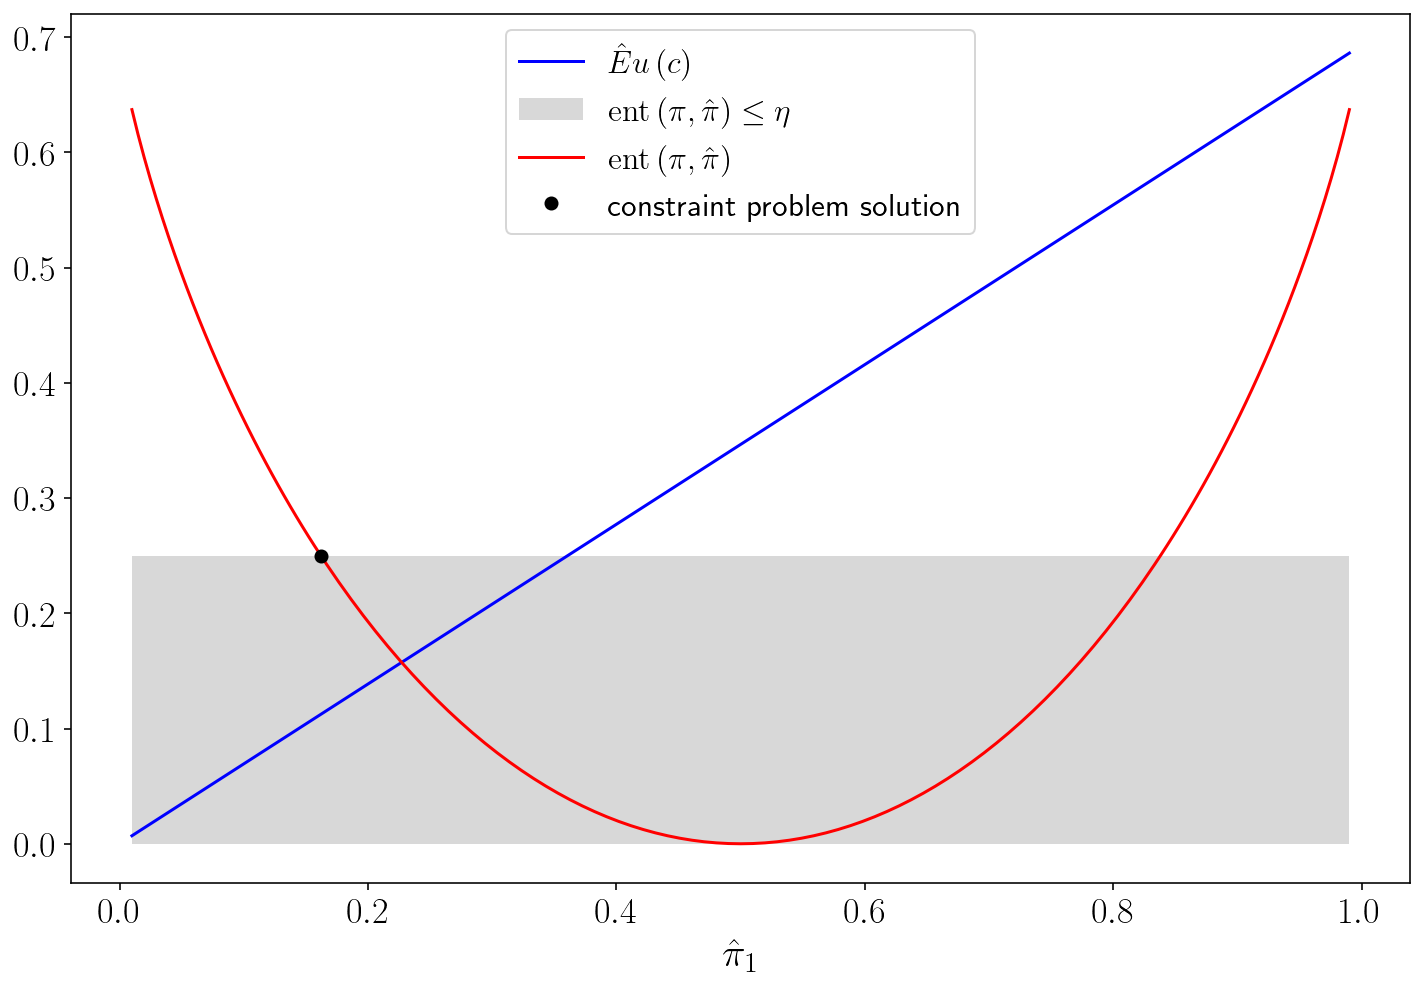

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(π_hat_0_vals, E_hat_uc, label=r'$\hat{E}u\left(c\right)$', color='blue')
plt.fill_between(π_hat_0_vals, η_line, alpha=0.3, label=r'$\mathrm{ent}\left(\pi,\hat{\pi}\right)\leq\eta$',
                 color='gray',
                 linewidth=0.0)
plt.plot(π_hat_0_vals, ent_vals, label=r'$\mathrm{ent}\left(\pi,\hat{\pi}\right)$', color='red')
plt.plot(root, η, 'o', color='black', label='constraint problem solution')
plt.xlabel(r'$\hat{\pi}_1$');
plt.legend();

The next  figure shows the function $\sum_{i=1}^I \pi_i m_i [  u(c_i) + \theta \log m_i ]$ that is to be
minimized in the multiplier problem.

The argument of the function is  $\hat \pi_1 = m_1 \pi_1$.

In [16]:
# Parameter values
θ_vals = np.array([0.42, 1.])

# Initialize values for storing the multiplier criterion values
multi_crit_vals = np.empty((θ_vals.size, π_hat_0_vals.size))

for i in range(θ_vals.size):  # Loop over θ values
    for j in range(π_hat_0_vals.size):  # Loop over π_hat_0 values
        # Update `π_hat` values
        π_hat[0] = π_hat_0_vals[j]
        π_hat[1] = 1 - π_hat_0_vals[j]
        
        # Compute distorting measure
        m_i = π_hat / π
        
        # Compute and store multiplier criterion objective value
        multi_crit_vals[i, j] = np.sum(π_hat * (u(c_bundle) + θ_vals[i] * np.log(m_i)))

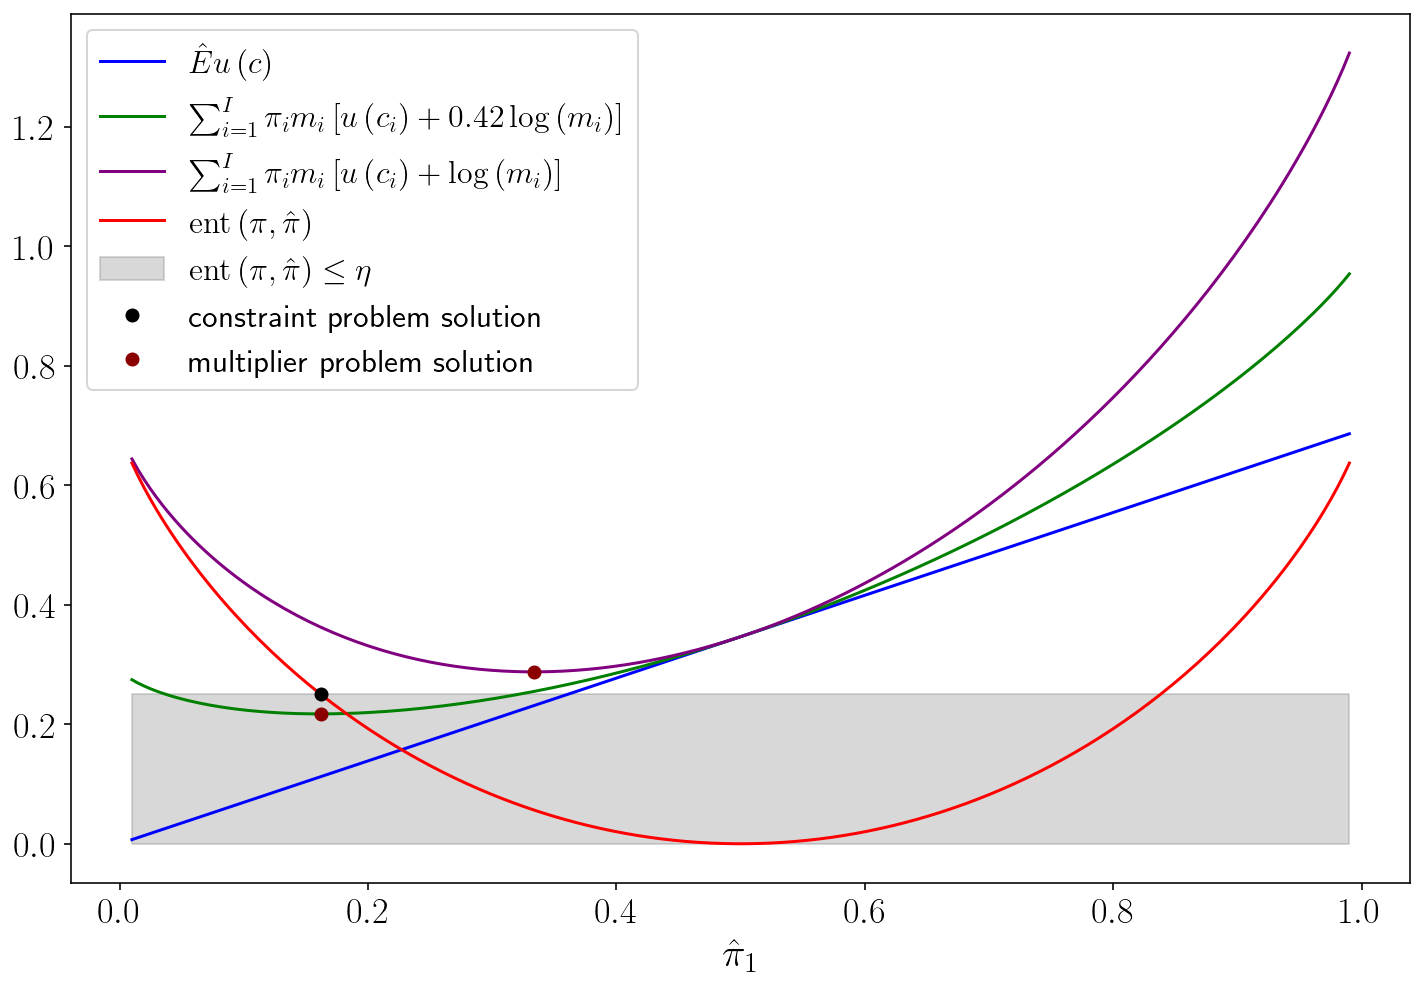

In [17]:
plt.figure(figsize=(12, 8))

# Expected utility values
plt.plot(π_hat_0_vals, E_hat_uc, label=r'$\hat{E}u\left(c\right)$', color='blue')

# First multiplier criterion objective values
plt.plot(π_hat_0_vals, multi_crit_vals[0],
         label=r'$\sum_{i=1}^{I}\pi_{i}m_{i}\left[u\left(c_{i}\right)+0.42\log\left(m_{i}\right)\right]$',
         color='green')

# Second multiplier criterion objective values
plt.plot(π_hat_0_vals, multi_crit_vals[1],
         label=r'$\sum_{i=1}^{I}\pi_{i}m_{i}\left[u\left(c_{i}\right)+\log\left(m_{i}\right)\right]$',
         color='purple')

# Entropy values
plt.plot(π_hat_0_vals, ent_vals, label=r'$\mathrm{ent}\left(\pi,\hat{\pi}\right)$', color='red')

# Area fill
plt.fill_between(π_hat_0_vals, η_line, alpha=0.3, label=r'$\mathrm{ent}\left(\pi,\hat{\pi}\right)\leq\eta$', color='gray')

# Problem solution dots
plt.plot(root, η, 'o', color='black', label='constraint problem solution')
plt.plot(π_hat_0_vals[multi_crit_vals[0].argmin()], multi_crit_vals[0].min(), 'o', label='multiplier problem solution', color='darkred')
plt.plot(π_hat_0_vals[multi_crit_vals[1].argmin()], multi_crit_vals[1].min(), 'o', color='darkred')

plt.xlabel(r'$\hat{\pi}_1$');
plt.legend();

Evidently, from this figure and also from formula {eq}`tom12`, lower values of $\theta$ lead to lower,
and thus more distorted, minimizing values of $\hat \pi_1$. 

The figure
indicates how one can construct a Lagrange multiplier $\tilde \theta$
associated with a given entropy constraint $\eta$ and a given
consumption plan. 

Thus, to draw the figure, we set the penalty parameter for
multiplier preferences $\theta$ so that the minimizing $\hat \pi_1$
equals the minimizing $\hat \pi_1$ for the constraint problem from
the previous figure.

The penalty parameter $\theta=.42$ also equals the
Lagrange multiplier $\tilde \theta$ on the entropy constraint for the
constraint preferences depicted in the previous figure
because the $\hat \pi_1$ that minimizes the
asymmetric curve associated with penalty parameter $\theta=.42$ is the
same $\hat \pi_1$ associated with the intersection of the entropy curve
and the entropy constraint dashed vertical
line.

## Risk aversion and misspecification aversion

All five types of preferences use curvature of $u$ to express risk
aversion. 

Constraint preferences express **concern about misspecification** or **ambiguity** for short with a positive
$\eta$ that circumscribes an entropy ball around an approximating
probability distribution $\pi$, and *aversion aversion to model misspecification* through
minimization with respect to a likelihood ratio $m$.

Multiplier preferences express misspecification concerns with a parameter $\theta<+\infty$ that
penalizes deviations from the approximating model as measured by
relative entropy, and they express  aversion to misspecification  concerns with minimization
over a probability distortion $m$. 

By penalizing minimization over the
likelihood ratio $m$, a decrease in $\theta$ represents an **increase** in
ambiguity (or what {cite}`Knight:1921` called uncertainty) about the specification of the baseline
approximating model $\{\pi_i\}_{i=1}^I$.

Formulas {eq}`tom6`  assert that the decision maker acts as if
he is pessimistic relative to an approximating model $\pi$. 

It expresses what {cite}`Bucklew_2004` [p. 27] calls a statistical version of *Murphy's law*:

**$\quad \quad$ The probability of anything happening is in inverse ratio to its desirability.**

The minimizing likelihood ratio $\hat m$ slants worst-case probabilities
$\hat \pi$ exponentially to increase probabilities of events that give
lower utilities. 

As expressed by the value function bound {eq}`eqn:bound1` to be displayed below, the decision maker uses **pessimism** instrumentally to protect himself against model misspecification. 

The penalty parameter $\theta$ for multipler preferences or the entropy level $\eta$ that determines the
Lagrange multiplier $\tilde \theta$ for constraint  preferences controls how adversely the decision maker exponentially slants probabilities.

A decision rule is said to be **undominated** in the sense of Bayesian
decision theory if there exists a probability distribution $\pi$ for
which it is optimal.

A decision rule is said to be **admissible** if it is undominated.

{cite}`HansenSargent2008` use ex post Bayesian preferences to show that robust
decision rules are undominated and therefore admissible.

## Indifference curves

Indifference curves illuminate how concerns about robustness affect
asset pricing and utility costs of fluctuations. For $I=2$, the slopes
of the indifference curves for our five preference specifications are

* Expected utility:
    
    $$
    \frac{d c_2}{d c_1} = - \frac{\pi_1}{\pi_2}\frac{u'(c_1)}{u'(c_2)}
    $$

* Constraint and ex post Bayesian preferences:
    
    $$
    \frac{d c_2}{d c_1} = - \frac{\hat \pi_1}{\hat \pi_2}\frac{u'(c_1)}{u'(c_2)}
    $$

    where $\hat \pi_1, \hat \pi_2$ are the minimizing probabilities
    computed from the worst-case distortions {eq}`tom6` from the constraint problem at  $(c_1, c_2)$.

* Multiplier and risk-sensitive preferences:
   
    $$
    \frac{d c_2}{d c_1} = - \frac{\pi_1}{\pi_2} \frac{\exp(- u(c_1)/\theta)}{\exp (- u(c_2)/\theta)}    \frac{u'(c_1)}{u'(c_2)}
    $$

When $c_1 > c_2$, the exponential twisting formula {eq}`tom12`
implies that $\hat \pi_1 < \pi_1$, which in
turn implies that the indifference curves through $(c_1, c_2)$ for both
constraint and multiplier preferences are flatter than the indifference
curve associated with expected utility preferences. 

As we shall see soon when we discuss state price
deflators, this gives rise to higher estimates of prices of risk.

For an example with $u(c) = \ln c$, $I=2$, and $\pi_1 = .5$, the next two  figures show indifference curves for expected
utility, multiplier, and constraint preferences. 


The following figure shows indifference curves going through a
point along the 45 degree line.

In [18]:
def multiplier_criterion_factory(θ, π, u):
    """
    Return a function to compute the multiplier preferences objective function parametrized 
    by a penalty parameter `θ`, a probability vector `π` and a utility function `u`
    
    """
    def criterion(c_1, c_2, return_entropy=False):
        """
        Compute the multiplier preferences objective function and
        associated entropy level if return_entropy=True for a
        consumption bundle (c_1, c_2).
        
        """
        # Compute the distorting measure
        m = compute_change_measure(u, np.array([c_1, c_2]), θ, π)
        
        # Compute objective value
        obj = π[0] * m[0] * (u(c_1) + θ * np.log(m[0])) + π[1] * m[1] * (u(c_2) + θ * np.log(m[1]))
        
        if return_entropy:        
            # Compute associated entropy value
            π_hat = np.array([π[0] * m[0], π[1] * m[1]])
            ent_val = ent(π, π_hat)
        
            return ent_val
        
        else:
            return obj
    
    return criterion


def constraint_criterion_factory(η, π, u):
    """
    Return a function to compute the constraint preferences objective function parametrized 
    by a penalty parameter `η`, a probability vector `π` and a utility function `u`
    
    """
    
    def inner_root_problem(θ_tilde, c_1, c_2):
        """
        Inner root problem associated with the constraint preferences objective function. 
        
        """
        # Compute the change of measure
        m = compute_change_measure(u, np.array([c_1, c_2]), θ_tilde, π)
            
        # Compute the associated entropy value
        π_hat = np.array([π[0] * m[0], π[1] * m[1]])
        ent_val = ent(π, π_hat)
        
        # Compute the error
        Δ = ent_val - η
        
        return ent_val - η
    
    def criterion(c_1, c_2, return_θ_tilde=False):
        try:
            # Solve for the Lagrange multiplier
            res = optimize.root_scalar(inner_root_problem, args=(c_1, c_2), bracket=[3e-3, 10.], method='bisect')
            
            if res.converged:
                θ_tilde = res.root

                # Compute change of measure
                m = compute_change_measure(u, np.array([c_1, c_2]), θ_tilde, π)

                obj = π[0] * m[0] * u(c_1) + π[1] * m[1] * u(c_2)

                if return_θ_tilde: 
                    return θ_tilde

                else: 
                    return obj

            else: 
                return np.nan
            
        except: 
            return np.nan
        
    return criterion


def solve_root_problem(problem, u_bar, c_1_grid, method='bisect', bracket=[0.5, 3.]):
    """
    Solve root finding problem `problem` for all values in `c_1_grid` taking `u_bar` as
    given and using `method`.
    
    """
    
    # Initialize array to be filled with c_2 values
    c_2_grid = np.empty(c_1_grid.size)
    
    for i in range(c_1_grid.size):  # Loop over c_1 values
        c_1 = c_1_grid[i]
        
        try: 
            # Solve root problem given c_1 and u_bar
            res = optimize.root_scalar(problem, args=(c_1, u_bar), bracket=bracket, method=method)

            if res.converged:  # Store values if successfully converged
                c_2_grid[i] = res.root
            else:  # Store np.nan otherwise
                c_2_grid[i] = np.nan
                
        except:
            c_2_grid[i] = np.nan
            
    return c_2_grid

In [19]:
# Parameters
c_bundle = np.array([1., 1.])  # Consumption bundle
u_inv = lambda x: np.exp(x)  # Inverse of the utility function
θ = 1.
η = 0.12


# Conustruct grid for c_1
c_1_grid_nb = 102
c_1_grid = np.linspace(0.5, 2., num=c_1_grid_nb)

# Compute \bar{u}
u_bar = u(c_bundle) @ π

# Compute c_2 values for the expected utility case
c_2_grid_EU = u_inv((u_bar - u(c_1_grid) * π[0]) / π[1])

# Compute c_2 values for the multiplier preferences case
multi_pref_crit = multiplier_criterion_factory(θ, π, u)  # Create criterion
multi_pref_root_problem = lambda c_2, c_1, u_bar: u_bar - multi_pref_crit(c_1, c_2)  # Formulate root problem
c_2_grid_mult = solve_root_problem(multi_pref_root_problem, u_bar, c_1_grid)  # Solve root problem for all c_1 values

# Compute c_2 values for the constraint preferences case
constraint_pref_crit = constraint_criterion_factory(η, π, u)  # Create criterion
constraint_pref_root_problem = lambda c_2, c_1, u_bar: u_bar - constraint_pref_crit(c_1, c_2)  # Formulate root problem
# Solve root problem for all c_1 values
c_2_grid_cons = solve_root_problem(constraint_pref_root_problem, u_bar, c_1_grid, method='bisect', bracket=[0.5, 2.5])  

# Compute associated η and θ values
ηs = np.empty(c_1_grid.size)
θs = np.empty(c_1_grid.size)

for i in range(c_1_grid.size):
    ηs[i] = multi_pref_crit(c_1_grid[i], c_2_grid_mult[i], return_entropy=True)
    θs[i] = constraint_pref_crit(c_1_grid[i], c_2_grid_cons[i], return_θ_tilde=True)
    
θs[~np.isfinite(c_2_grid_cons)] = np.nan

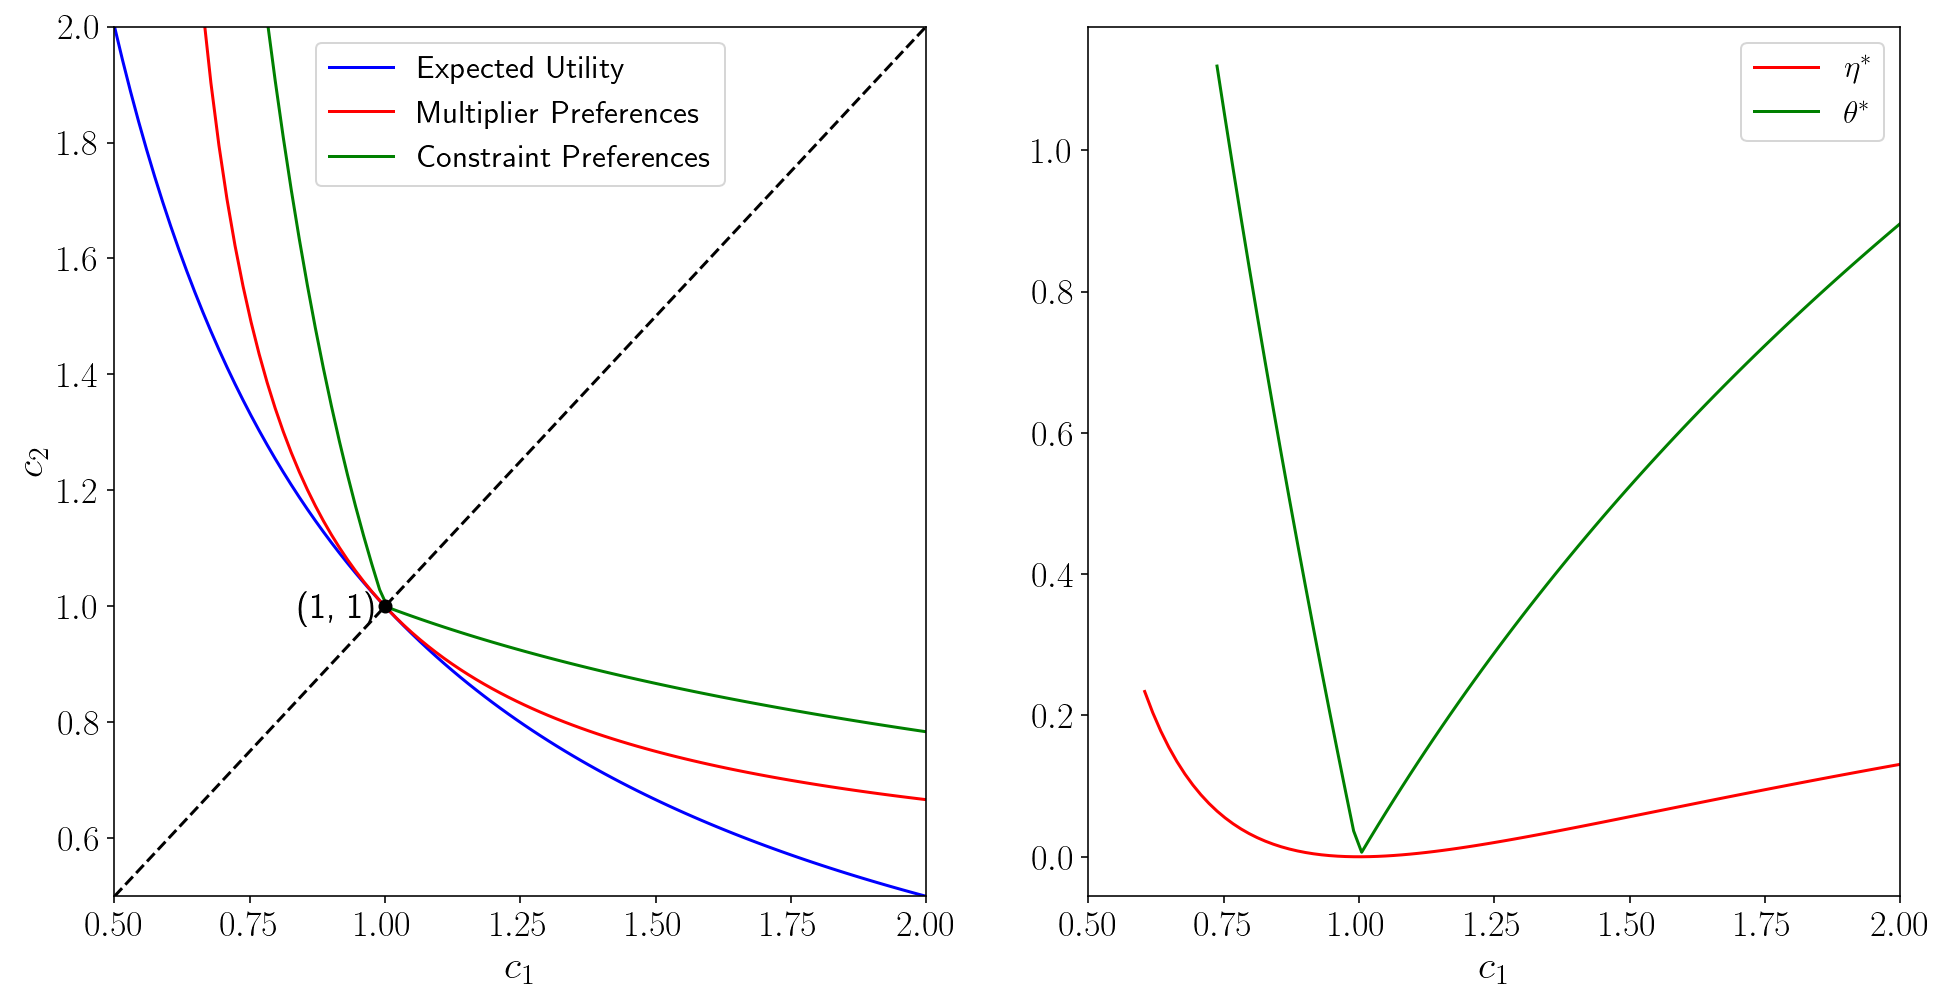

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

ax1.plot(c_1_grid, c_1_grid, '--', color='black')
ax1.plot(c_1_grid, c_2_grid_EU, label='Expected Utility', color='blue')
ax1.plot(c_1_grid, c_2_grid_mult, label='Multiplier Preferences', color='red')
ax1.plot(c_1_grid, c_2_grid_cons, label='Constraint Preferences', color='green')
ax1.plot(1., 1., 'o', color='black')
ax1.set_xlabel(r'$c_1$')
ax1.set_ylabel(r'$c_2$')
ax1.annotate('(1, 1)', (1-0.16, 1-0.02))
ax1.set_ylim(0.5, 2.)
ax1.set_xlim(0.5, 2.)
ax1.legend();

ax2.plot(c_1_grid, ηs, label=r'$\eta^{*}$', color='red')
ax2.plot(c_1_grid, θs, label=r'$\theta^{*}$', color='green')
ax2.set_xlabel(r'$c_1$')
ax2.legend();

**Kink at 45 degree line**


Notice the kink in the indifference curve for constraint  preferences at the 45 degree line.  

To understand the source of the kink, consider how the Lagrange multiplier and worst-case probabilities vary with the consumption plan under  constraint preferences. 

For fixed $\eta$, a given plan $c$, and a utility function increasing in $c$,  worst case probabilities are **fixed numbers** $\hat \pi_1 < .5$ when $c_1 > c_2$ and $\hat \pi_1 > .5$ when
$c_2 > c_1$. 

This pattern makes the Lagrange multiplier $\tilde \theta$ vary discontinuously at $\hat \pi_1 = .5$. 

The  discontinuity in the worst case $\hat \pi_1$ at the 45 degree line accounts for the kink at the 45 degree line in an indifference curve for constraint preferences associated with a given positive entropy constraint $\eta$. 

The code for generating the preceding figure is somewhat intricate we formulate a root finding problem for finding indifference curves.

Here is a brief literary  description of the method we use.

**Parameters**

- Consumption bundle $c=\left(1,1\right)$
- Penalty parameter $θ=2$
- Utility function $u=\log$
- Probability vector $\pi=\left(0.5,0.5\right)$

**Algorithm:**
- Compute $\bar{u}=\pi_{1}u\left(c_{1}\right)+\pi_{2}u\left(c_{2}\right)$
- Given values for $c_{1}$, solve for values of $c_{2}$ such that $\bar{u}=u\left(c_{1},c_{2}\right)$:
     - Expected utility: $c_{2,EU}=u^{-1}\left(\frac{\bar{u}-\pi_{1}u\left(c_{1}\right)}{\pi_{2}}\right)$
     - Multiplier preferences: solve $\bar{u}-\sum_{i}\pi_{i}\frac{\exp\left(\frac{-u\left(c_{i}\right)}{\theta}\right)}{\sum_{j}\exp\left(\frac{-u\left(c_{j}\right)}{\theta}\right)}\left(u\left(c_{i}\right)+\theta\log\left(\frac{\exp\left(\frac{-u\left(c_{i}\right)}{\theta}\right)}{\sum_{j}\exp\left(\frac{-u\left(c_{j}\right)}{\theta}\right)}\right)\right)=0$ numerically
     - Constraint preference: solve $\bar{u}-\sum_{i}\pi_{i}\frac{\exp\left(\frac{-u\left(c_{i}\right)}{\theta^{*}}\right)}{\sum_{j}\exp\left(\frac{-u\left(c_{j}\right)}{\theta^{*}}\right)}u\left(c_{i}\right)=0$ numerically where $\theta^{*}$ solves $\sum_{i}\pi_{i}\frac{\exp\left(\frac{-u\left(c_{i}\right)}{\theta^{*}}\right)}{\sum_{j}\exp\left(\frac{-u\left(c_{j}\right)}{\theta^{*}}\right)}\log\left(\frac{\exp\left(\frac{-u\left(c_{i}\right)}{\theta^{*}}\right)}{\sum_{j}\exp\left(\frac{-u\left(c_{j}\right)}{\theta^{*}}\right)}\right)-\eta=0$ numerically.
     

**Remark:** It seems that the constraint problem is hard to solve in its original form, i.e. by finding the distorting measure that minimizes the expected utility. 

It seems that viewing equation {eq}`tom7` as a root finding problem works much better. 

But notice that  equation {eq}`tom7` does not always have a solution. 

Under $u=\log$, $c_{1}=c_{2}=1$, we have: 

$$
\sum_{i}\pi_{i}\frac{\exp\left(\frac{-u\left(c_{i}\right)}{\tilde{\theta}}\right)}{\sum_{j}\pi_{j}\exp\left(\frac{-u\left(c_{j}\right)}{\tilde{\theta}}\right)}\log\left(\frac{\exp\left(\frac{-u\left(c_{i}\right)}{\tilde{\theta}}\right)}{\sum_{j}\pi_{j}\exp\left(\frac{-u\left(c_{j}\right)}{\tilde{\theta}}\right)}\right)=0
$$

**Conjecture:** when our numerical  method fails it  because the derivative of the objective doesn't exist for our choice of  parameters.

**Remark:** It is tricky to get the algorithm  to work properly for all values of $c_{1}$. In particular, parameters were chosen with [graduate student descent](https://sciencedryad.wordpress.com/2014/01/25/grad-student-descent/).


**Tangent indifference curves off 45 degree line**

For a given $\eta$ and a given allocatin $(c_1, c_2)$ off the 45 degree line, by solving
equations {eq}`tom7` and {eq}`tom20`, we can find $\tilde \theta (\eta, c)$
and $\tilde \eta(\theta,c)$ that make indifference curves for 
multiplier and constraint preferences be tangent to one another.

The following figure shows indifference curves for
multiplier and constraint preferences through a point off the 45 degree
line, namely, $(c(1),c(2)) = (3,1)$, at which $\eta$ and $\theta$ are
adjusted to render the indifference curves for constraint and multiplier
preferences tangent.

In [21]:
# Parameters
θ = 2.
η = 0.036
c_bundle = np.array([3., 1.])

# Conustruct grid for c_1
c_1_grid_num = 101
c_1_grid = np.linspace(0.5, 4., num=c_1_grid_num)

# Compute u_bar
u_bar = u(c_bundle) @ π

# Compute c_2 values for the expected utility case
c_2_grid_EU = u_inv((u_bar - u(c_1_grid) * π[0]) / π[1])

# Compute c_2 values for the multiplier preferences case
multi_pref_crit = multiplier_criterion_factory(θ, π, u)  # Create criterion
multi_crit_bar = multi_pref_crit(*c_bundle)  # Evaluate criterion at consumption bundle
multi_pref_root_problem = lambda c_2, c_1, u_bar: u_bar - multi_pref_crit(c_1, c_2)  # Formulate root problem
# Solve root problem for all c_1 values
c_2_grid_mult = solve_root_problem(multi_pref_root_problem, multi_crit_bar, c_1_grid, bracket=[1e-5, 5.])  

# Compute c_2 values for the constraint preferences case
constraint_pref_crit = constraint_criterion_factory(η, π, u)  # Create criterion
cons_crit_bar = constraint_pref_crit(*c_bundle)  # Evaluate criterion at consumption bundle
constraint_pref_root_problem = lambda c_2, c_1, u_bar: u_bar - constraint_pref_crit(c_1, c_2)  # Formulate root problem
# Solve root problem for all c_1 values
c_2_grid_cons = solve_root_problem(constraint_pref_root_problem, cons_crit_bar, c_1_grid, method='bisect', bracket=[0.3, 4.4])  

# Compute associated η and θ values
ηs = np.empty(c_1_grid.size)
θs = np.empty(c_1_grid.size)

for i in range(c_1_grid.size):
    ηs[i] = multi_pref_crit(c_1_grid[i], c_2_grid_mult[i], return_entropy=True)
    θs[i] = constraint_pref_crit(c_1_grid[i], c_2_grid_cons[i], return_θ_tilde=True)
    
θs[~np.isfinite(c_2_grid_cons)] = np.nan

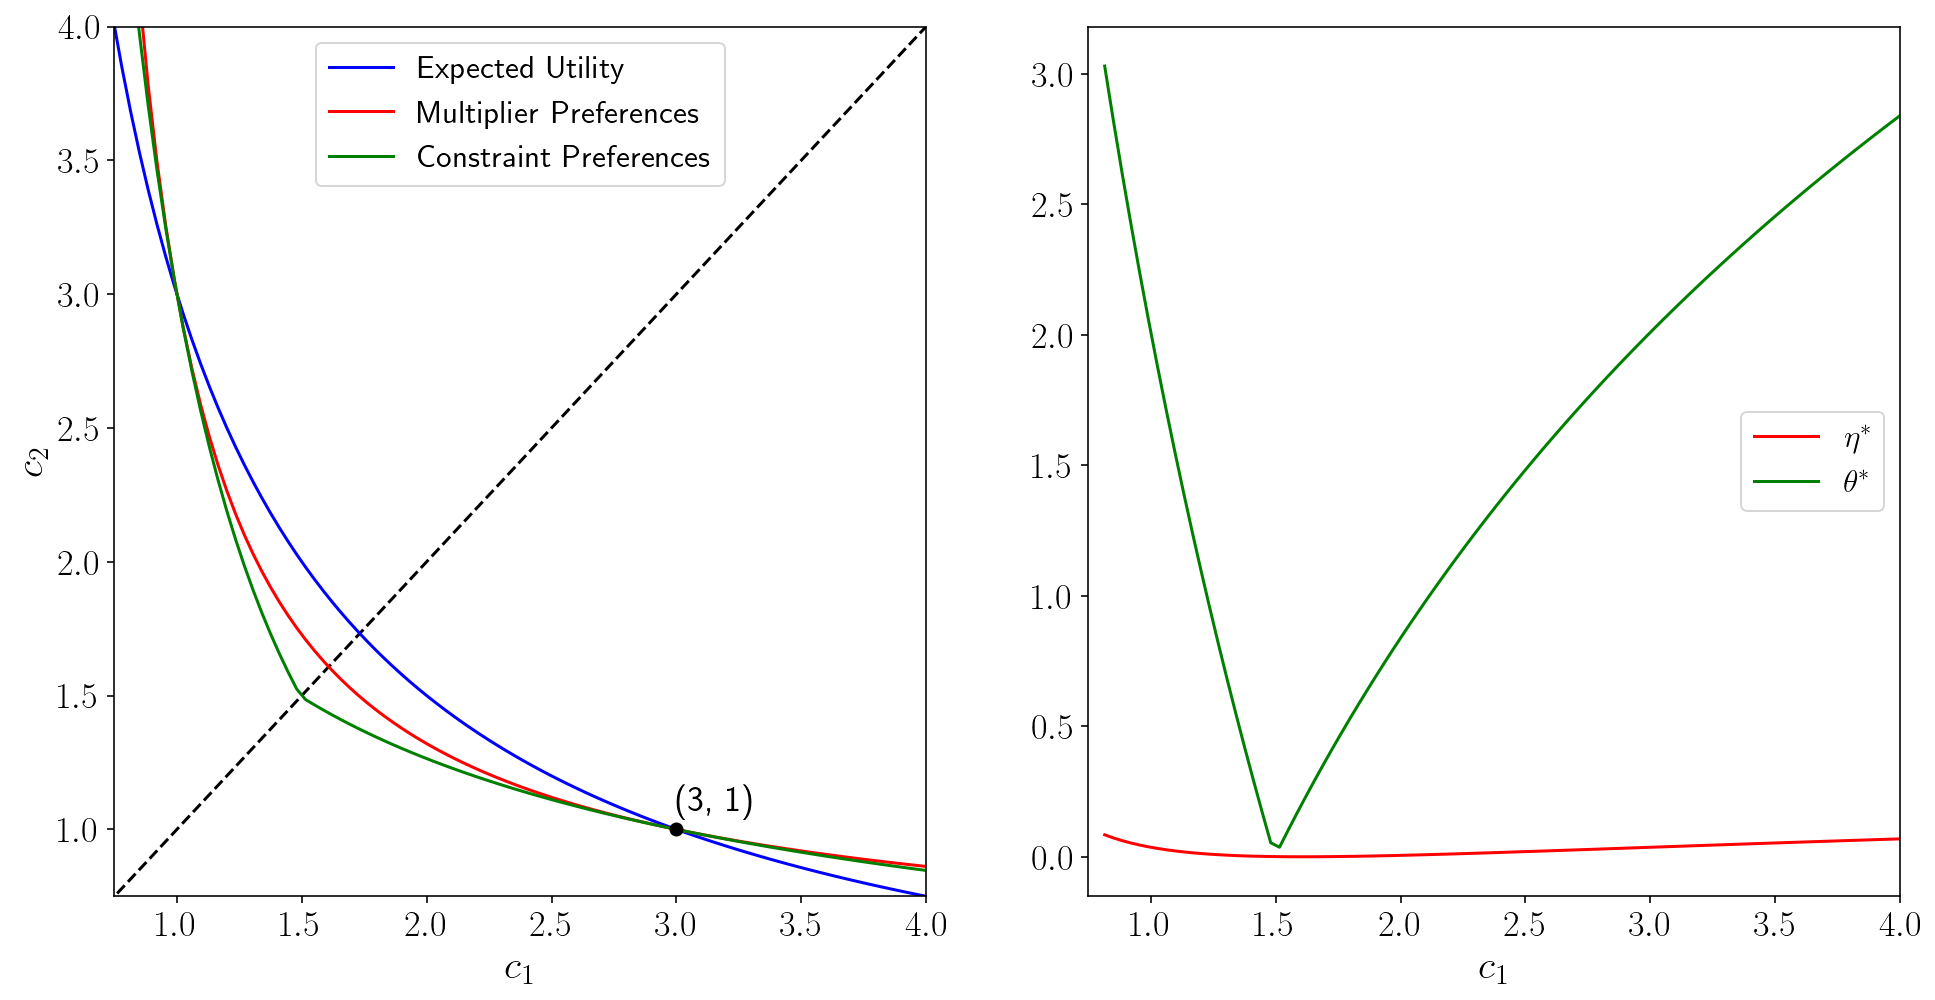

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

ax1.plot(c_1_grid, c_1_grid, '--', color='black')
ax1.plot(c_1_grid, c_2_grid_EU, label='Expected Utility', color='blue')
ax1.plot(c_1_grid, c_2_grid_mult, label='Multiplier Preferences', color='red')
ax1.plot(c_1_grid, c_2_grid_cons, label='Constraint Preferences', color='green')
ax1.plot(3., 1., 'o', color='black')
ax1.set_xlabel(r'$c_1$')
ax1.set_ylabel(r'$c_2$')
ax1.annotate('(3, 1)', (3, 1+0.07))
ax1.set_ylim(0.75, 4.)
ax1.set_xlim(0.75, 4.)
ax1.legend();

ax2.plot(c_1_grid, ηs, label=r'$\eta^{*}$', color='red')
ax2.plot(c_1_grid, θs, label=r'$\theta^{*}$', color='green')
ax2.set_xlabel(r'$c_1$')
ax2.legend();

Note that all three lines of the left graph intersect at (1, 3). While the intersection at (3, 1) is hard-coded, the intersection at (1,3) arises from the computation,  which confirms that the code seems to be
working properly.


As we move along the (kinked) indifference curve for the constraint
preferences for a given $\eta$, the worst-case probabilities remain
constant, but the Lagrange multiplier $\tilde \theta$ on the entropy
constraint $\sum_{i=1}^I m_i \log m_i \leq \eta$ varies with
$(c_1, c_2)$. 

As we move along the (smooth) indifference curve for the
multiplier preferences for a given penalty parameter $\theta$, the
implied entropy $\tilde \eta$ from equation {eq}`tom20` and the worst-case probabilities both
change with $(c_1, c_2)$.

For constraint preferences, there is a kink in the indifference curve. 

For ex post Bayesian preferences, there are effectively two sets of indifference curves depending on which
side of the 45 degree line the $(c_1, c_2)$ endowment point sits.

There are two sets of indifference curves because, while the worst-case
probabilities differ above and below the 45 degree line, the idea of ex
post Bayesian preferences is to use a *single* probability distribution
to compute expected utilities for all consumption bundles.

Indifference curves through point $(c_1, c_2) = (3,1)$ for expected
logarithmic utility (less curved smooth line), multiplier (more curved
line), constraint (solid line kinked at 45 degree line), and *ex post*
Bayesian (dotted lines) preferences. The worst-case probability
$\hat \pi_1 < .5$ when $c_1 =3 > c_2 =1$ and $\hat \pi_1 > .5$ when
$c_1=1 < c_2 = 3$.


## State price deflators

Concerns about model uncertainty boost prices of risk that are embedded
in state-price deflators. With complete markets, let $q_i$ be the price
of consumption in state $i$. 

The budget set of a representative consumer
having endowment $\bar c = \{\bar c_i\}_{i=1}^I$ is expressed by
$\sum_{i}^I q_i (c_i - \bar c_i) \leq 0$. 

When a representative consumer has multiplier preferences, the state prices are

$$
q_i = \pi_i \hat m_i u'(\bar c_i) = \pi_i \Biggl(\frac{\exp(-u(\bar c_i)/\theta)}{\sum_j  \pi_j \exp(-u(\bar c_j)/\theta)}\Biggr) u'(\bar c_i) .
$$ (eqn:state_price)

The worst-case likelihood ratio $\hat m_i$ operates to increase prices
$q_i$ in relatively low utility states $i$.

State prices agree under multiplier and constraint preferences when $\eta$ and $\theta$ are
adjusted according to {eq}`tom7` or {eq}`tom20` to make the indifference curves tangent
at the endowment point. 

The next figure can help us think about state-price deflators under our different preference orderings.

In this figure, budget line and indifference curves through point $(c_1, c_2) = (3,1)$
for expected logarithmic utility, multiplier, constraint (kinked at 45
degree line), and *ex post* Bayesian (dotted lines) preferences. 

**Figure 2.7:**

In [23]:
# Parameters
θ = 2.
η = 0.036
c_bundle = np.array([3., 1.])
u = utility_function_factory(1.)
u_prime = lambda c: 1 / c  # Derivative of the utility function

# Compute value of θ at c_1=3
θ = np.interp(3., c_1_grid, θs)

# Compute change of measure
m = compute_change_measure(u, c_bundle, θ, π)

# Compute budget constraint
q = π * m * u_prime(c_bundle)
endowment = (c_bundle * q).sum()
intercept = endowment / q[1]
slope = -q[0] / q[1]
budget_constraint = slope * c_1_grid + intercept

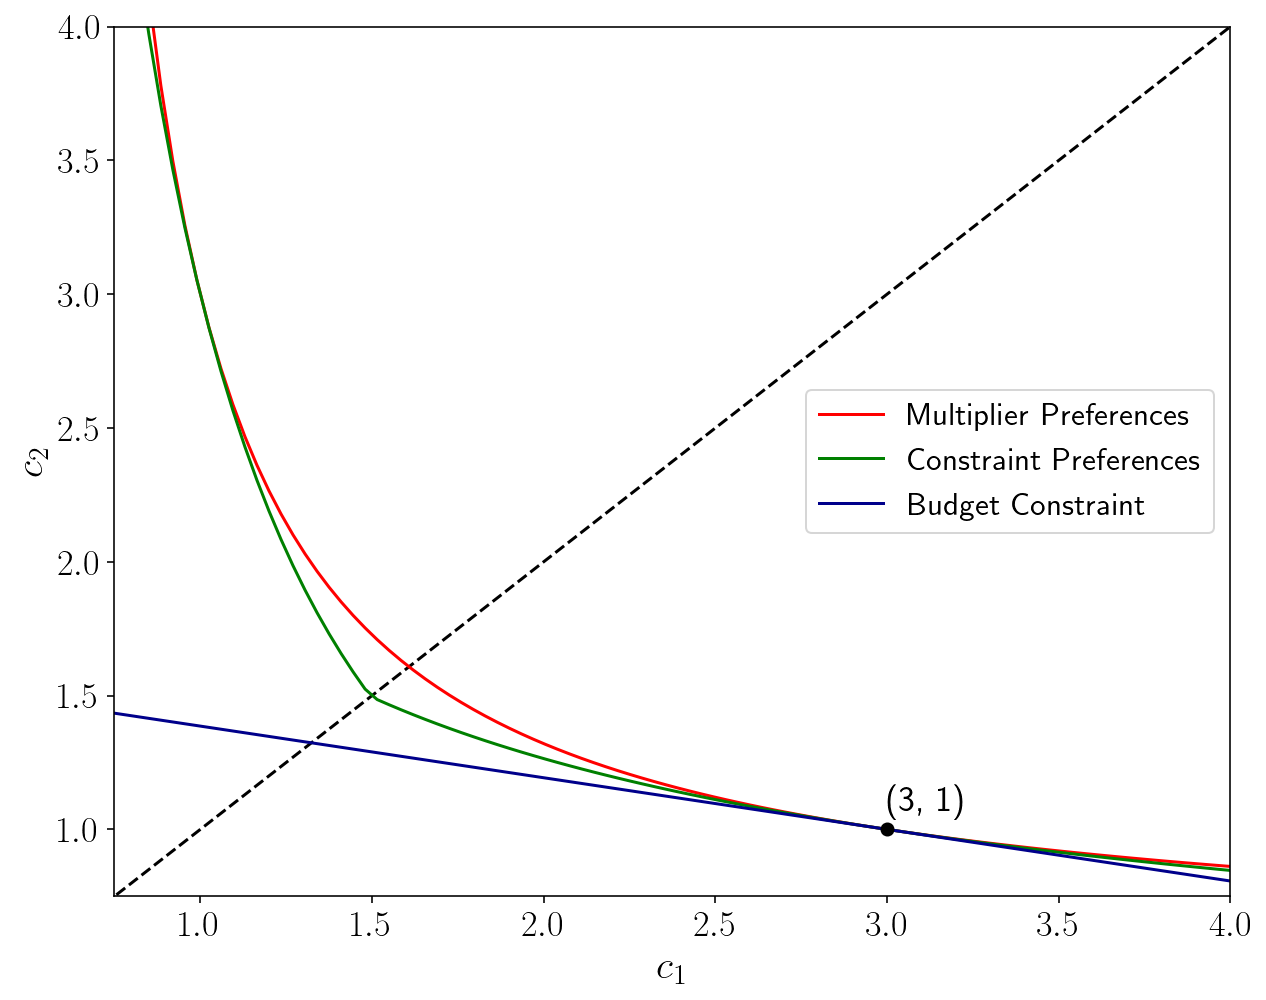

In [24]:
plt.figure(figsize=(10, 8))

plt.plot(c_1_grid, c_1_grid, '--', color='black')
plt.plot(c_1_grid, c_2_grid_mult, label='Multiplier Preferences', color='red')
plt.plot(c_1_grid, c_2_grid_cons, label='Constraint Preferences', color='green')
plt.plot(c_1_grid, budget_constraint, label='Budget Constraint', color='darkblue')
plt.plot(3., 1., 'o', color='black')
plt.xlabel(r'$c_1$')
plt.ylabel(r'$c_2$')
plt.annotate('(3, 1)', (3, 1+0.07))
plt.ylim(0.75, 4.)
plt.xlim(0.75, 4.)
plt.legend();

Because budget constraints are linear, asset prices are identical under
multiplier and constraint preferences for which $\theta$ and $\eta$ are
adjusted to verify {eq}`tom7` or {eq}`tom20` at a given consumption endowment
$\{c_i\}_{i=1}^I$. 

However, as we note next, though they are tangent at
the endowment point, the fact that indifference curves differ for
multiplier and constraint preferences means that certainty equivalent
consumption compensations of the kind that {cite}`Lucas1987`,
{cite}`HST_1999`, {cite}`Tall2000`, and {cite}`BHS_2009` used to measure the costs of
business cycles must differ. 


### Consumption-equivalent measures of uncertainty aversion

For each of our five types of preferences, the following figure allows us to construct a certainty
equivalent point $(c^*, c^*)$ on the 45 degree line that renders the consumer indifferent between it and the risky point
$(c(1), c(2)) = (3,1)$. 

**Figure 2.8:**

In [25]:
# Compute values for the certainty equivalent line 
intercept = 4.  # Intercept value
mask = (1. <= c_1_grid) & (c_1_grid <= 3.)  # Mask to keep only data between c_1=1 and c_1=3

# Initialize array 
certainty_equiv = np.ones(c_1_grid.size) * np.nan

# Fill relevant locations
certainty_equiv[mask] = (intercept - c_1_grid)[mask]


# Set up a fixed point problem to find intersections with x=x line
# Function used to approximate indifference curves using linear interpolation
func_approx = lambda c_1, fp: np.interp(c_1, c_1_grid, fp)  
x0 = 2.  # Initial guess

# Solve for fixed points
fp_CE = optimize.fixed_point(func_approx, x0, args=([certainty_equiv]))
fp_EU = optimize.fixed_point(func_approx, x0, args=([c_2_grid_EU]))
fp_mult = optimize.fixed_point(func_approx, x0, args=([c_2_grid_mult]))
fp_cons = optimize.fixed_point(func_approx, x0, args=([c_2_grid_cons]))

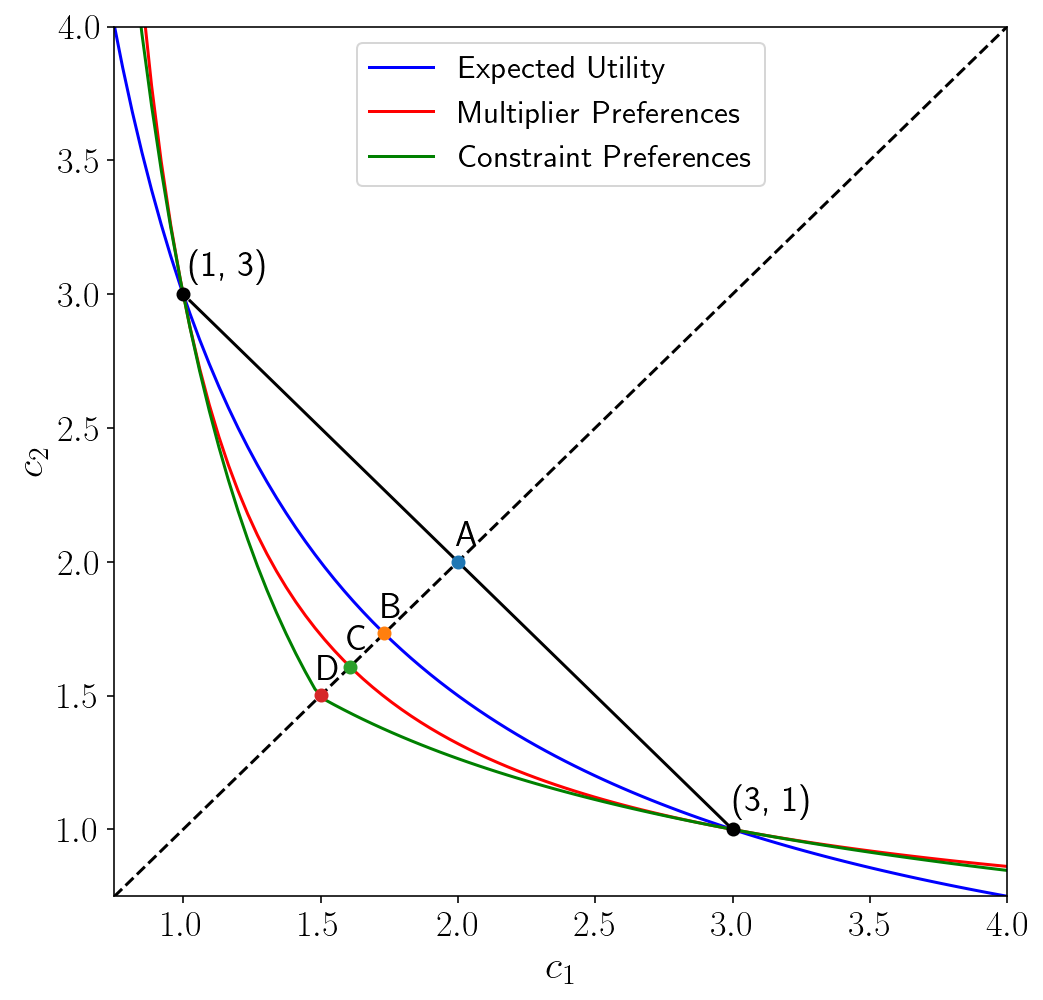

In [26]:
plt.figure(figsize=(8, 8))

plt.plot(c_1_grid, c_1_grid, '--', color='black')
plt.plot(c_1_grid, c_2_grid_EU, label='Expected Utility', color='blue')
plt.plot(c_1_grid, c_2_grid_mult, label='Multiplier Preferences', color='red')
plt.plot(c_1_grid, c_2_grid_cons, label='Constraint Preferences', color='green')
plt.plot(c_1_grid, certainty_equiv, color='black')
plt.plot(3., 1., 'o', color='black')
plt.plot(1., 3., 'o', color='black')
plt.xlabel(r'$c_1$')
plt.ylabel(r'$c_2$')
plt.annotate('(3, 1)', (3, 1+0.07))
plt.annotate('(1, 3)', (1+0.02, 3+0.07))
plt.ylim(0.75, 4.)
plt.xlim(0.75, 4.)

plt.plot(fp_CE, fp_CE, 'o')
plt.plot(fp_EU, fp_EU, 'o')
plt.plot(fp_mult, fp_mult, 'o')
plt.plot(fp_cons, fp_cons, 'o')

plt.annotate('A', (fp_CE-0.01, fp_CE+0.06))
plt.annotate('B', (fp_EU-0.01, fp_EU+0.06))
plt.annotate('C', (fp_mult-0.01, fp_mult+0.06))
plt.annotate('D', (fp_cons-0.01, fp_cons+0.06))

plt.legend();

The figure indicates that the certainty equivalent
level $c^*$ is higher for the consumer with expected utility preferences
than for the consumer with multiplier preferences, and that it is higher
for the consumer with multiplier preferences than for the consumer with
constraint preferences. 

The gap between these certainty equivalents
measures the uncertainty aversion of the multiplier preferences or
constraint preferences consumer. 

The gap between the expected value
$.5 c(1) + .5 c(2)$ at point A and the certainty equivalent for the
expected utility decision maker at point B is a measure of his risk
aversion. 

The gap between points $B$ and $C$ measures the multiplier
preference consumer's aversion to model uncertainty. 

The gap between
points B and D measures the constraint preference consumer's aversion to
model uncertainty.

## Iso-utility and iso-entropy curves and expansion paths

The following figures show iso-entropy and iso-utility lines for the special case in which $I = 3$, $\pi_1 = .3, \pi_2 = .4$, and the utility function is $u(c)= \frac{c^{1-\alpha}}{1-\alpha}$ with $\alpha =0$ and $\alpha =3$, respectively, for the fixed plan $c(1) = 1, c(2) =2 , c(3) =3$.

The iso-utility lines are the level curves of

$$ 
\hat \pi_1 c_1 + \hat \pi_2 c_2 + (1-\hat \pi_1 - \hat \pi_2) c_3
$$

and are linear in $(\hat \pi_1, \hat \pi_2)$. 

This is what it means to say 'expected utility is linear in probabilities.'

Both figures plot the locus of points of tangency between the iso-entropy and the iso-utility
curves that is traced out as one varies $\theta^{-1}$ in the interval
$[0, 2]$. 

While the iso-entropy lines are identical in the two figures, these 'expansion paths' differ because the utility functions differ,
meaning that for a given $\theta$ and $(c_1, c_2, c_3)$ triple, the worst-case probabilities $\hat \pi_i(\theta) =  \pi_i \frac{\exp(-u(c_i)/\theta )} {E\exp(-u(c)/\theta )}$ differ as we vary $\theta$, causing the associated entropies to differ.


**Color bars:** 

* First color bar: variation in $\theta$  
* Second color bar: variation in utility levels  
* Third color bar: variation in entropy levels

In [27]:
# Plotting functions
def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    plt.colorbar(lc)
    
    return lc

In [28]:
# Parameters
π_1 = 0.3
π_2 = 0.4
π_3 = 1 - π_1 - π_2
π_base = np.array([π_1, π_2, π_3])
c_bundle = np.array([1., 2., 3.])


def contour_plot(α, π_vals_nb=200, levels_nb=20, min_π_val=1e-8):
    """
    Create a contour plot containing iso-utility and iso-entropy curves given utility
    function parameter `α`.
    
    """
    
    # Create utility function
    u = utility_function_factory(α)

    # Initialize arrays 
    π_hat = np.empty(3)
    EU_levels = np.empty((π_vals_nb, π_vals_nb))
    ent_levels = np.empty_like(EU_levels)

    # Create grids for π_hat_1 and π_hat_2 values
    π_hat_1_vals = np.linspace(min_π_val, 1.-min_π_val, π_vals_nb)
    π_hat_2_vals = np.linspace(min_π_val, 1.-min_π_val, π_vals_nb)

    # Evaluate utility function at consumption bundle
    u_c_bundle = u(c_bundle)

    # Loop over all (π_hat_1,  π_hat_2) pairs
    for i, π_hat_1 in enumerate(π_hat_1_vals):
        for j, π_hat_2 in enumerate(π_hat_2_vals):
            # Update π_hat vector with current values
            π_hat[0] = π_hat_1
            π_hat[1] = π_hat_2
            π_hat[2] = 1 - π_hat[0] - π_hat[1]

            # Compute and store expected utility and entropy level if π_hat is a valid probability vector
            if 0. <= π_hat[2] <= 1:
                EU_levels[j, i] = np.sum(π_hat * u_c_bundle)
                ent_levels[j, i] = ent(π_base, π_hat)
            else: 
                EU_levels[j, i] = np.nan
                ent_levels[j, i] = np.nan
                
    # Create grid of θ values
    θ_vals = np.linspace(1e-4, 2., num=50)
    π_hat_coord = np.empty((π_base.size, θ_vals.size))
    
    # For each θ, compute distorted probability distribution
    for i in range(θ_vals.size):  
        m = compute_change_measure(u, c_bundle, θ_vals[i], π_base)
        π_hat_coord[:, i] = π_base * m
    
    # Create contour plot
    plt.figure(figsize=(14, 6))
    plt.contour(π_hat_1_vals, π_hat_2_vals, EU_levels, levels=levels_nb, cmap='spring')
    plt.colorbar()
    plt.contour(π_hat_1_vals, π_hat_2_vals, ent_levels, levels=levels_nb, cmap='winter')
    plt.colorbar()
    colorline(π_hat_coord[0, :], π_hat_coord[1, :], z=θ_vals)
    plt.xlabel(r'$\hat{\pi}_{1}$')
    plt.ylabel(r'$\hat{\pi}_{2}$')

/tmp/ipykernel_13712/3904427642.py:36: RuntimeWarning: invalid value encountered in true_divide
  m =  m_unnormalized / (π * m_unnormalized).sum()


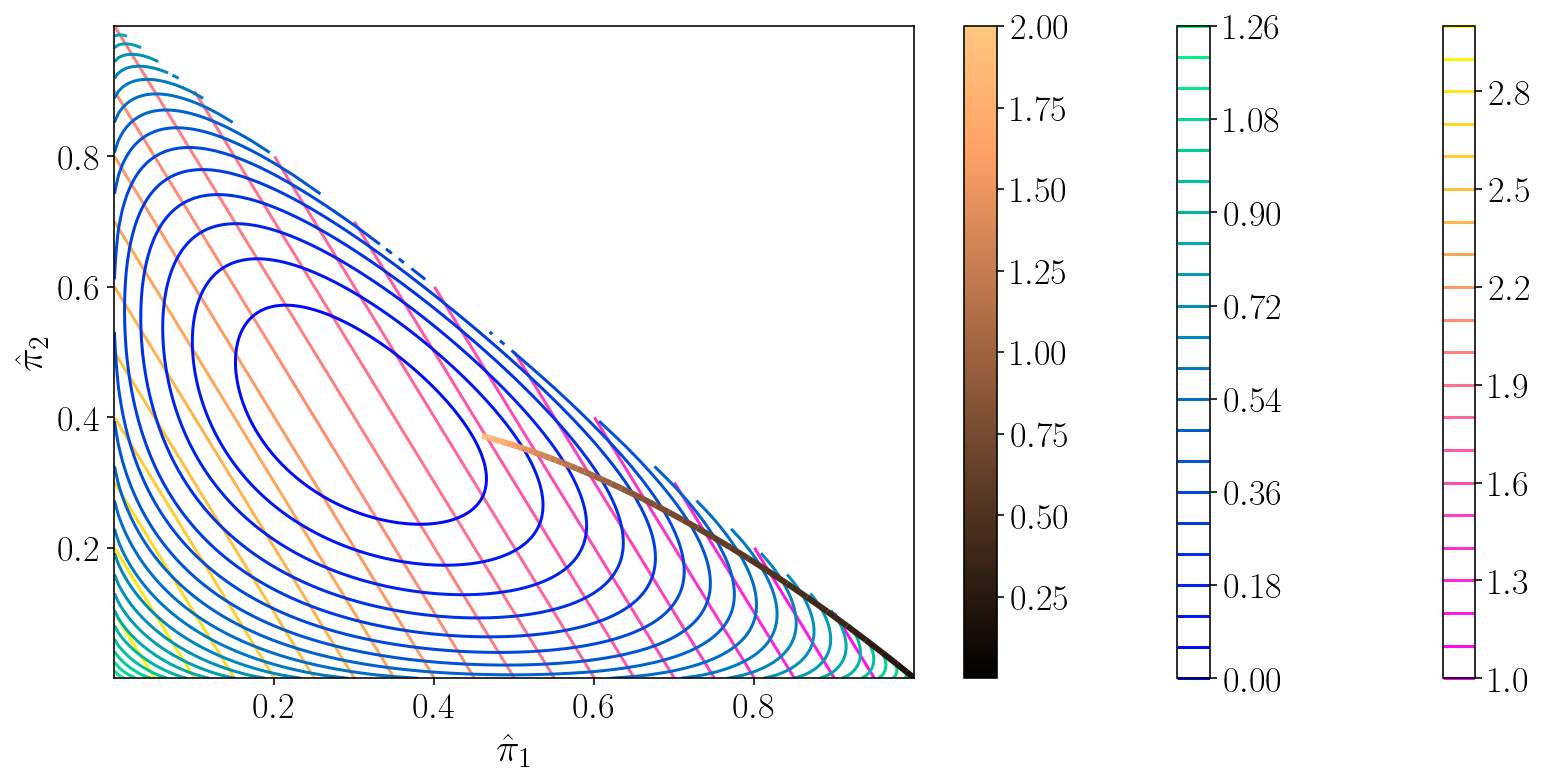

In [29]:
α = 0.

contour_plot(α)

/tmp/ipykernel_13712/3904427642.py:35: RuntimeWarning: overflow encountered in exp
  m_unnormalized = np.exp(-u(c) / θ)
/tmp/ipykernel_13712/3904427642.py:36: RuntimeWarning: invalid value encountered in true_divide
  m =  m_unnormalized / (π * m_unnormalized).sum()


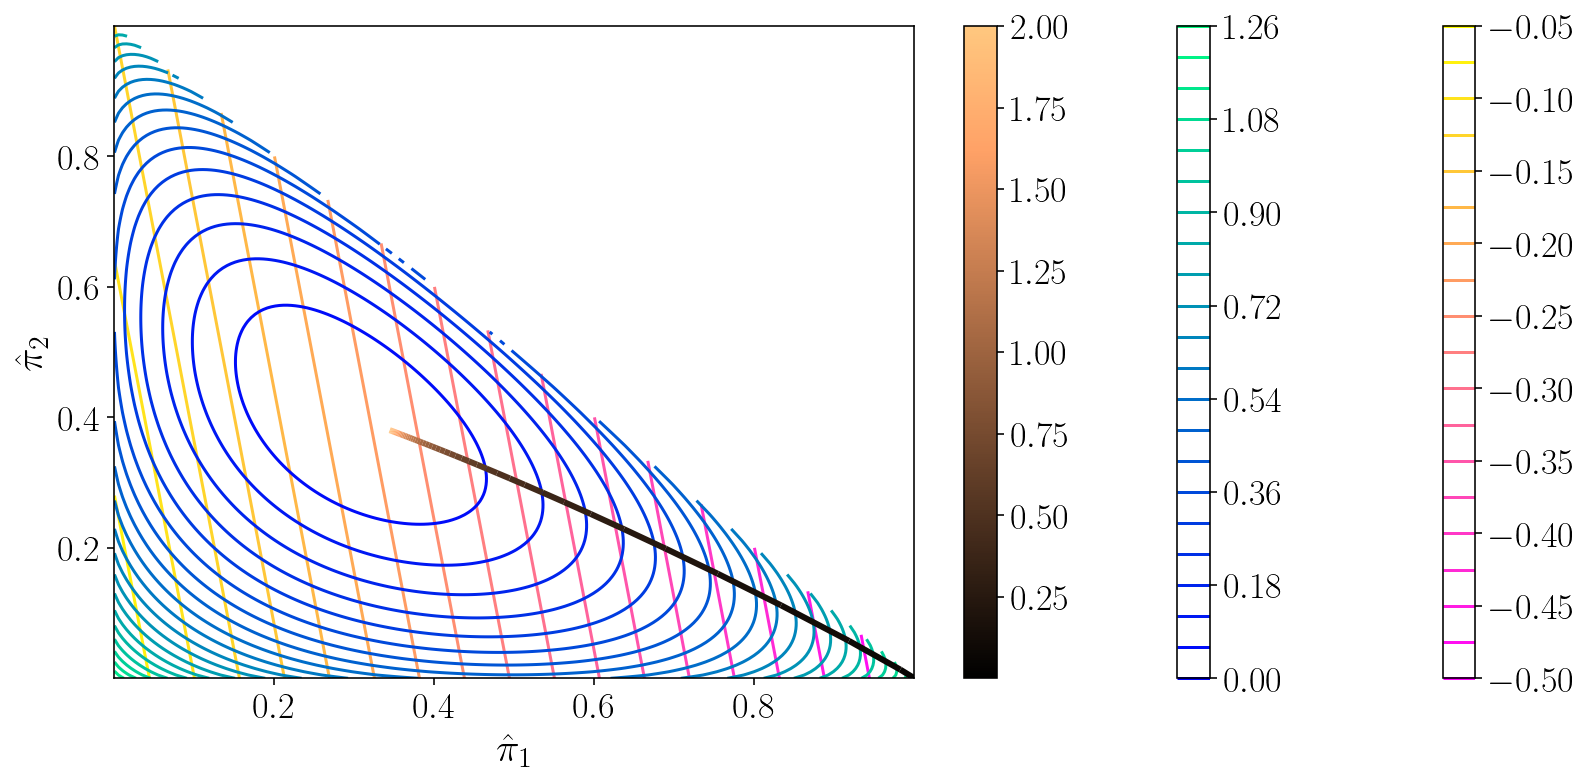

In [30]:
α = 3.

contour_plot(α)

## Bounds on expected utility

Suppose that a decision maker wants a lower bound on expected utility
$\sum_{i=1}^I  \hat \pi_i u(c_i)$ that is satisfied for **any**
distribution $\hat \pi$ with relative entropy less than or equal to
$\eta$. 

An attractive feature of multiplier and constraint preferences
is that they carry with them such a bound.

To show this, it is useful to collect some findings in the following
string of inequalities associated with multiplier preferences:


$$
\begin{aligned}
{\sf T}_\theta u(c) & = & -\theta \log \sum_{i=1}^I \exp\Biggl(\frac{-u(c_i)}{\theta}\Biggr) \pi_i \nonumber \\
    & = & \sum_{i=1}^I m_i^* \pi_i \bigl( u(c_i) + \theta \log m_i^* \bigr) \nonumber \\
    & \leq & \sum_{i=1}^I m_i \pi_i u(c_i) + \theta \sum_{i=1}^i m_i \log m_i \pi_i
\end{aligned}
$$

where $m_i^* \propto \exp \Bigl( \frac{- u(c_i)}{\theta} \Bigr)$ are the
worst-case distortions to probabilities.

The inequality in the last line just asserts that minimizers minimize.

Therefore, we have the following useful bound:

$$
\sum_{i=1}^I m_i \pi_i u(c_i ) \geq {\sf T}_\theta u(c) - \theta \sum_{i=1}^I \pi_i m_i \log m_i .
$$ (eqn:bound1)

The left side is expected utility under the probability distribution $\{ m_i \pi_i\}$. 

The right side is a *lower bound* on expected utility
under *all* distributions expressed as an affine function of relative
entropy $\sum_{i=1}^I \pi_i m_i \log m_i$.

The bound is attained for $m_i =  m_i^* \propto \exp \Bigl(\frac{- u (c_i)}{\theta} \Bigr)$.
 
The *intercept* in the bound is the risk-sensitive criterion ${\sf T}_\theta u(c)$, while the *slope* is the penalty parameter $\theta$. 

Lowering $\theta$ does two things:

* it lowers the intercept ${\sf T}_\theta u(c)$, which makes the bound less informative for small
values of entropy; and

* it lowers the absolute value of the slope, which makes the bound more informative for larger values of relative
entropy $\sum_{i=1}^I \pi_i m_i \log m_i$.

The following figure reports  best-case and worst-case expected utilities.

We calculate the lines in this figure  numerically by solving optimization problems with respect to the change of measure.

In [31]:
# Parameters
α = 3
u = utility_function_factory(α)
u_c_bundle = u(c_bundle)

# Create grid for η values 
η_vals_nb = 100
η_vals = np.linspace(1e-10, 0.08, η_vals_nb)


# Initialize arrays to be filled by minimum and maximum expected utility values
min_EU = np.empty(η_vals_nb)
min_EU[:] = np.nan
max_EU = min_EU.copy()


@njit
def objective(m_0_and_1, η):
    """
    Compute expected utility with respect to the distorted probability measure
    given the first two values of the change of measure `m_0_and_1`. 
    
    """
    # Back out third implied value for the change of measure
    m_2 = (1 - (π_base[:2] * m_0_and_1).sum()) / π_base[2]
    
    # Compute distorted probability measure π_hat
    m = np.array([m_0_and_1[0], m_0_and_1[1], m_2])
    π_hat = π_base * m
    
    # Compute expected utility wrt π_hat
    EU = np.sum(π_hat * u_c_bundle)
    
    # Return np.inf if entropy constraint is violated
    if ent(π_base, π_hat) > η:
        return np.inf
    
    # Return np.inf if π_hat is not a valid probability vector
    if not ((0. <= π_hat) & (π_hat <= 1.)).all():
        return np.inf
    
    return EU


@njit
def max_obj_wrapper(m_0_and_1, η):
    """
    Wrap `objective` to make it suitable for maximization using minimization routines.
    
    """
    obj_val = objective(m_0_and_1, η)
    if np.isfinite(obj_val):
        return -obj_val
    else:
        return obj_val

In [32]:
method = 'Nelder-Mead'
m_0_and_1 = np.ones(2)  # Initial guess

# Compute worst-case expected utility values
for i in range(η_vals_nb):
    opt_res = optimize.minimize(objective, m_0_and_1, method=method, args=(η_vals[i]))
    opt_res = optimize.minimize(objective, opt_res.x, method=method, args=(η_vals[i]))
    if opt_res.success:
        min_EU[i] = opt_res.fun
         
# Compute best-case expected utility values
for i in range(η_vals_nb):
    opt_res = optimize.minimize(max_obj_wrapper, m_0_and_1, method=method, args=(η_vals[i]))
    opt_res = optimize.minimize(max_obj_wrapper, opt_res.x, method=method, args=(η_vals[i]))
    if opt_res.success:
        max_EU[i] = -opt_res.fun

In [33]:
# Compute lower bound line
θ = 1.269230769133136
T_θ = T_θ_factory(θ, π_base)
intercept = T_θ(u)(c_bundle)
lower_bound = intercept - θ * η_vals

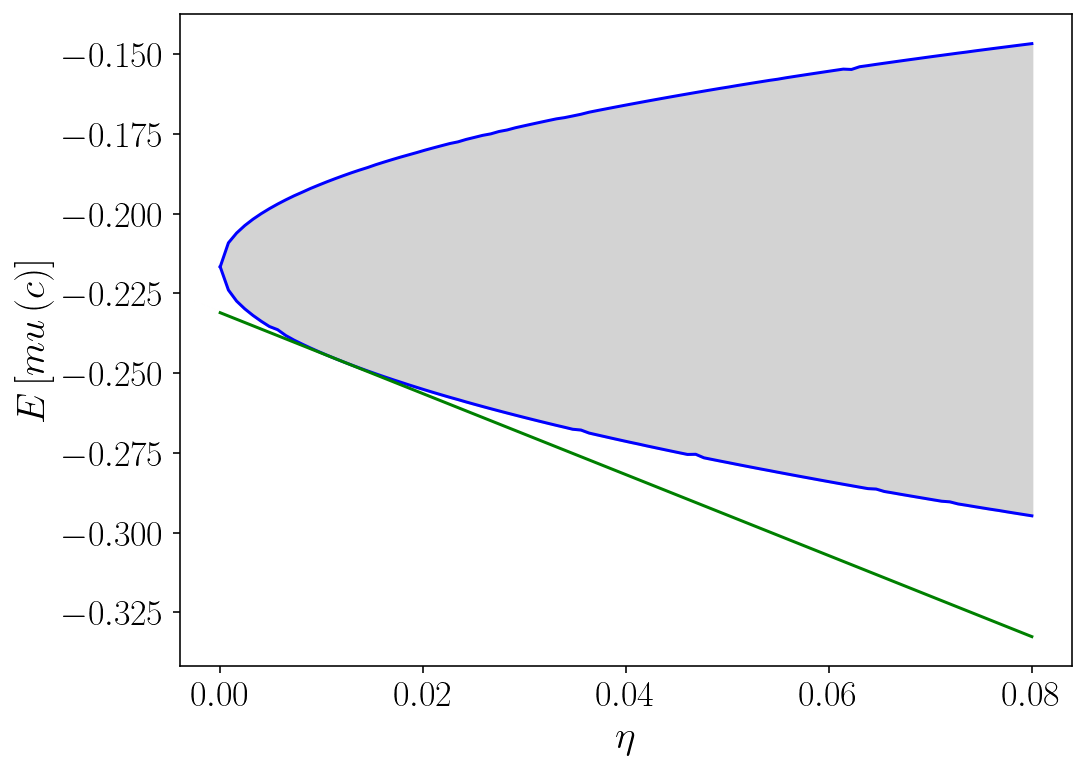

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(η_vals, min_EU, color='blue')
plt.plot(η_vals, max_EU, color='blue')
plt.fill_between(η_vals, min_EU, max_EU, color='lightgray');
plt.plot(η_vals, lower_bound, color='green')
plt.ylabel(r'$E\left[mu\left(c\right)\right]$');
plt.xlabel(r'$\eta$');

In this figure, expected utility is on the co-ordinate axis
while entropy is on the ordinate axis. 

The *lower* curved line depicts
expected utility under the worst-case model associated with each value
of entropy $\eta$ recorded on the ordinate axis, i.e., it is
$\sum_{i=1}^I \pi_i \tilde m_i (\tilde \theta(c,\eta)) u(c_i)$, where
$\tilde m_i (\tilde \theta(\eta)) \propto \exp \Bigl(\frac{-u(c_i)}{\tilde \theta}\Bigr)$
and $\tilde \theta$ is the Lagrange multiplier associated with the
constraint that entropy cannot exceed the value on the ordinate axis.

The *higher* curved line depicts expected utility under the *best*-case
model indexed by the value of the Lagrange multiplier $\check \theta >0$
associated with each value of entropy less than or equal to $\eta$
recorded on the ordinate axis, i.e., it is
$\sum_{i=1}^I \pi_i \check m_i (\check \theta(\eta)) u(c_i)$ where
$\check m_i (\check \theta(c,\eta)) \propto \exp \Bigl(\frac{u(c_i)}{\check \theta}\Bigr)$.

(Here $\check \theta$ is the Lagrange multiplier associated with
max-max expected utility.) 

Points between these two curves are
possible values of expected utility for some distribution with entropy
less than or equal to the value $\eta$ on the ordinate axis. 

The straight line depicts the right side of inequality {eq}`eqn:bound1` for a particular value of the penalty parameter
$\theta$. 

As noted, when one lowers $\theta$, the intercept ${\sf T}_\theta u(c)$ and the absolute value of the slope both decrease.

Thus, as $\theta$ is lowered, ${\sf T}_\theta u(c)$ becomes a more
conservative estimate of expected utility under the approximating model
$\pi$. 

However, as $\theta$ is lowered, the robustness bound {eq}`eqn:bound1` becomes more informative for sufficiently large
values of entropy.

The slope of straight line depicting a bound is $-\theta$ and the projection of the point of tangency with the curved
depicting the lower bound of expected utility is the entropy associated
with that $\theta$ when it is interpreted as a Lagrange multiplier on
the entropy constraint in the constraint problem .

This is an application of the envelope theorem.


## Why entropy?

Beyond the helpful mathematical fact that it leads directly to
convenient exponential twisting formulas {eq}`tom6` and
{eq}`tom12` for worst-case probability distortions,
there are two related justifications for using entropy to measure
discrepancies between probability distribution.

One arises from the role of entropy in statistical tests for discriminating between models. 

The other comes from axioms.

### Entropy and statistical detection

Robust control theory starts with a decision maker who has constructed a
good baseline approximating model whose free parameters he has estimated
to fit historical data well. 

The decision maker recognizes that actual outcomes might be generated by one of a vast number of other models that fit the historical data nearly as well as his. 

Therefore, he wants to evaluate outcomes under a set of alternative models that are plausible
in the sense of being statistically close to his model.

He uses relative entropy to quantify what  close means.

{cite}`AHS_2003` and {cite}`BHS_2009`describe links between entropy and large deviations
bounds on test statistics for discriminating between models, in particular, statistics that describe the probability of making an error in applying a likelihood ratio test to decide whether model A or model B
generated a data record of length $T$. 

For a given sample size, an
informative bound on the detection error probability is a function of
the entropy parameter $\eta$ in constraint preferences. {cite}`AHS_2003` and {cite}`BHS_2009`
use detection error probabilities to calibrate reasonable values of $\eta$.

{cite}`AHS_2003`  and  {cite}`HansenSargent2008` also
use detection error probabilities to calibrate reasonable values of the
penalty parameter $\theta$ in multiplier preferences. 

For a fixed sample size and a fixed $\theta$, they would calculate the worst-case
$\hat m_i(\theta)$, an associated entropy $\eta(\theta)$, and an
associated detection error probability. In this way they build up a
detection error probability as a function of $\theta$.

They then invert this function to calibrate $\theta$ to deliver a reasonable detection
error probability.

To indicate outcomes from this approach, the following figure
plots the histogram for U.S. quarterly consumption growth along with a
representative agent's approximating density and a worst-case density
that {cite}`BHS_2009` show imply high measured market prices of risk even when a
representative consumer has the unit coefficient of relative risk
aversion associated with a logarithmic one-period utility function.

In [35]:
# Load data
data = loadmat('dataBHS.mat')

# Set parameter values
μ_c = 0.004952
σ_c = 0.005050;
μ_c_tilde = μ_c - σ_c * 0.304569723799467

In [36]:
# Compute consumption growth
c = data['c']
c_growth = c[1:] - c[:-1]

# Create histogram of consumption growth
nb_bins = 30
cnt, bins = np.histogram(c_growth, bins=nb_bins)

bins_min = bins.min()
bins_max = bins.max()

# Create grid for PDF values
pdf_x = np.linspace(bins_min, bins_max, num=100)

# Evaluate PDF at grid points
approx = stats.norm(loc=μ_c, scale=σ_c).pdf(pdf_x)
worst_case = stats.norm(loc=μ_c_tilde, scale=σ_c).pdf(pdf_x)

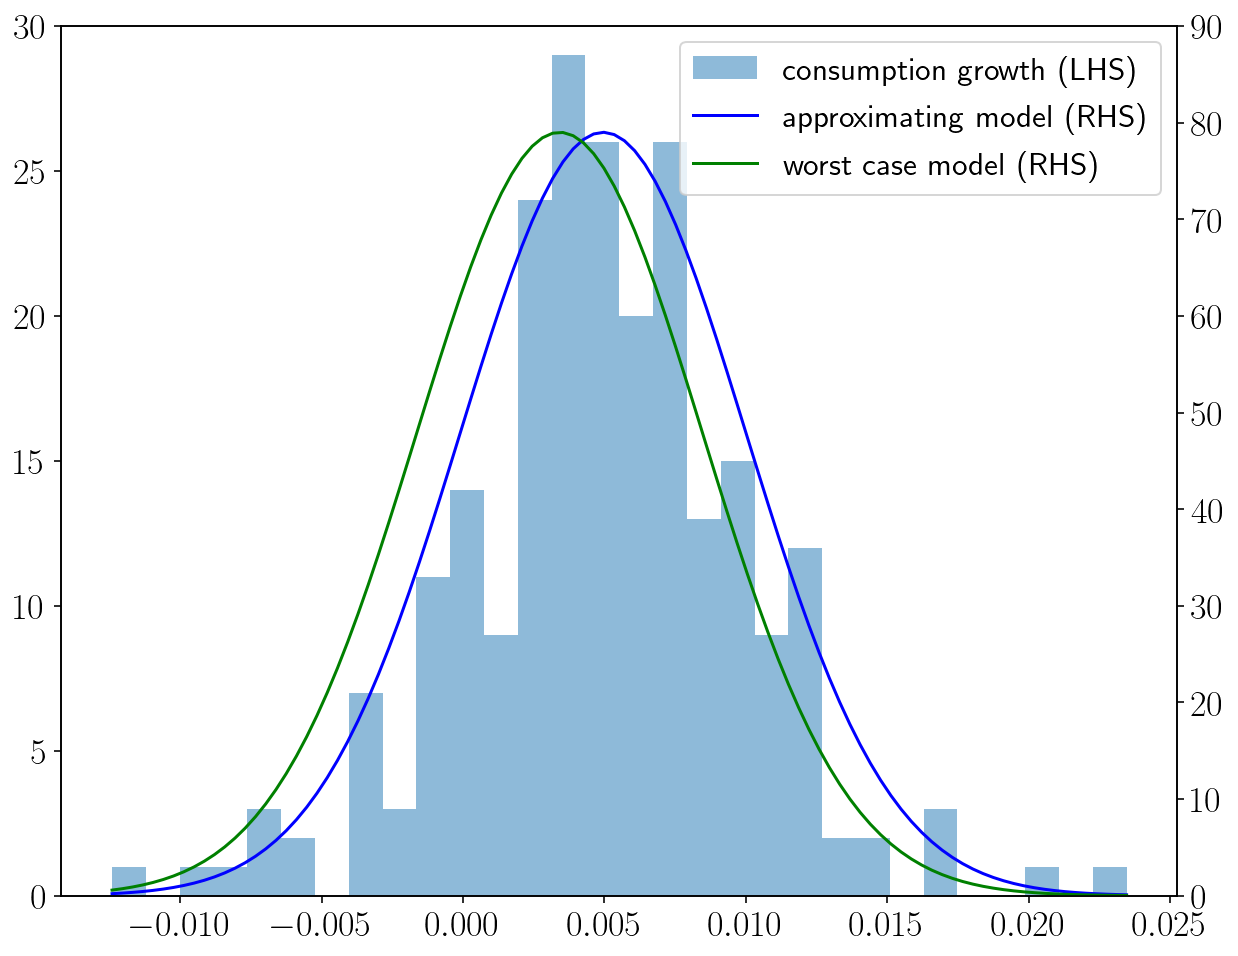

In [37]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
lns1 = ax.hist(c_growth, bins=bins, alpha=0.5, label='consumption growth (LHS)')
ax.set_ylim(0, 30.)
ax2 = ax.twinx()
lns2 = ax2.plot(pdf_x, approx, color='blue', label='approximating model (RHS)')
lns3 = ax2.plot(pdf_x, worst_case, color='green', label='worst case model (RHS)')
ax2.set_ylim(0, 90.)

lns = [lns1[2][0]]+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0);

In [38]:
rc('text',usetex=True)

The density for the approximating model is
$\log c_{t+1} - \log c_t = \mu + \sigma_c \epsilon_{t+1}$ where
$\epsilon_{t+1} \sim {\cal N}(0,1)$ and $\mu$ and $\sigma_c$ are
estimated by maximum likelihood from the U.S. quarterly data in the
histogram over the period 1948.I-2006.IV. 

The consumer's value function under logarithmic utility implies that the worst-case model is
$\log c_{t+1} - \log c_t = (\mu + \sigma_c w)  + \sigma_c \tilde \epsilon_{t+1}$
where $\{\tilde \epsilon_{t+1}\}$ is also a normalized Gaussian random
sequence and where $w$ is calculated by setting a detection error
probability to $.05$. 

The worst-case model appears to fit the histogram nearly as well as the approximating model.

### Axiomatic justifications

Multiplier and constraint preferences are both special cases of what
{cite}`MaccheroniMarinacciRustichini:2006b` call variational preferences. 

They provide an axiomatic foundation for variational preferences and describe how they
express ambiguity aversion.

Constraint preferences are particular instances of the multiple priors model of {cite}`GilboaSchmeidler:1989`.